In [ ]:
#####################################################################
#   PROJET 5 - Catégorisez automatiquement des questions            #
#-------------------------------------------------------------------#
#   NOTEBOOK DE TEST :                                              #
#      ---> test des différents modèles.                            #
#####################################################################

In [ ]:
#!pip install pyldavis

In [1]:
# built-in (librairie par défaut avec python)
import os

# Data
import pandas as pd
import numpy as np

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint
import tqdm
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Réduction de dimension
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer

# Algorithmes
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC       # SVM
from sklearn.svm import LinearSVC # SVM
from sklearn.ensemble import RandomForestClassifier

# Métriques
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, f1_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
from sklearn.metrics import jaccard_score
    
# Visualisation
import matplotlib.pyplot as plt
from PIL import Image

# Time
import time
from time import perf_counter

# Word2Vec
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


In [146]:
# Constantes
C_DATASET_SOURCE  = './data/source/'
C_DATASET_CLEANED = './data/cleaned/'

In [3]:
###############################################################
# Affichage durée programme                                   #
###############################################################
def affichage_duree_programme(time_start_sec, time_stop_sec) :
    
    # Delta time in seconds
    delta_time_sec = time_stop_sec - time_start_sec
    
    # Delta time in minutes
    delta_time_min = delta_time_sec / 60
    
    print('Durée programme (start : {:.3f}'.format(time_start_sec), '--> stop : {:.3f}'.format(time_stop_sec), ') = '
          '{:.3f}'.format(delta_time_sec), 'sec ou {:.3f}'.format(delta_time_min), 'min\n')

# 1. DONNEES

In [131]:
################################################
#      Chargement jeu de données               #
################################################
# Données nettoyées
df_all = pd.read_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', sep = '\t')

# Données nettoyées réduites
df = pd.read_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean_light.csv', sep = '\t')

In [132]:
print('df_all\tshape =', df_all.shape)
print('df\tshape =', df.shape)

df_all	shape = (185179, 17)
df	shape = (185179, 11)


In [133]:
df_all.columns

Index(['CreationDate', 'Id', 'Score', 'AnswerCount', '_Text', '_Tag_1',
       '_Tag_2', '_Text_sans_html', '_Text_tokens', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_len_Text', '_Tokens_text_clean',
       '_Tokens_stemmer_clean', '_Tokens_lemma_clean', '_len_Text_clean'],
      dtype='object')

In [134]:
df.columns

Index(['Id', 'Score', 'AnswerCount', '_Tag_1', '_Tag_2', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_Tokens_text_clean',
       '_Tokens_stemmer_clean', '_Tokens_lemma_clean'],
      dtype='object')

In [136]:
############## SUPPRIMER (début)
#df = df.loc[0:14999, :]
#df.shape

###########################
#lignes_a_supprimer = []
#
liste_tags = ['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'css', 'html', 'ios', 'iphone', 'java', 'javascript',
              'jquery', 'json', 'linux', 'mysql', 'node.js', 'objective-c', 'performance', 'php', 'python', 'reactjs', 
              'ruby-on-rails', 'spring', 'sql', 'swift', 'windows', 'xcode']

df.drop(['_Text_clean', '_Text_clean'], axis = 1, inplace = True)

for index, row in df.iterrows():
    if (df.loc[index, '_Tag_2'] == '/'):
        df.loc[index, '_Tag_2'] = ''
    if ((df.loc[index, '_Tag_1'] not in liste_tags) |
        (df.loc[index, '_Tag_2'] not in liste_tags)):
        lignes_a_supprimer.append(index)        

df.drop(lignes_a_supprimer, axis = 0, inplace = True)
print("==>", len(lignes_a_supprimer), "ligne(s) supprimée(s).")

# SOLUTION 1 :
#for index, row in df.iterrows():
#    if ((df.loc[index, '_Tag_1'] not in liste_tags) |
#        (df.loc[index, '_Tag_2'] not in liste_tags)):
#        lignes_a_supprimer.append(index)
#
#df.drop(lignes_a_supprimer, axis = 0, inplace = True)
#print("==>", len(lignes_a_supprimer), "ligne(s) supprimée(s).")

#--------------------------------------------------
# SOLUTION 2 :
#for index, row in df.iterrows():
#    if (df.loc[index, '_Tag_2'] == '/'):
#        lignes_a_supprimer.append(index)
#df.drop(lignes_a_supprimer, axis = 0, inplace = True)
#print("==>", len(lignes_a_supprimer), "ligne(s) supprimée(s).")
############## SUPPRIMER (fin)

==> 373750 ligne(s) supprimée(s).


In [137]:
df.shape

(56828, 10)

# 1.1. CORPUS TEXTE

In [ ]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.

In [139]:
# Colonne _Stemmer_clean
corpus_stemmer = ' '.join(df['_Stemmer_clean'])

print('taille corpus_stemmer =', f"{len(corpus_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_stemmer[:1_000])

taille corpus_stemmer = 15,369,854 

perform class radio time process time process perform store configur load input web configur instanc partial trust solut add memori disk tell time final save disk verifi handl load test perform limit limit behind enumer rang take repeat wizard limit return string format string cat cat append append cat string string cat cat string string format cat edit string string inject string get environ get environ set host solut asp solut server either server let prefer bit add port servic get version load take get bit server build server turn veloc client server servic bit bit instal servic architectur offic instanc vista translat subscrib happi forward respons live respond let trust enterpris experiment next time version vista system imag sampl find refer go add imag refer version sampl refer shot import either sampl configur war process handl configur take distribut configur intern java apach common verbos format client perspect product day angl edit platf

In [140]:
# Colonne _Lemma_clean
corpus_lemma = ' '.join(df['_Lemma_clean'])

print('taille corpus_lemma =', f"{len(corpus_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_lemma[:1_000])

taille corpus_lemma = 16,534,268 

performance class radio time process time process performance store configuration load input web configuration instance partial trust solution add memory disk tell time final save disk verify handle load testing performance limit limit behind enumerable range take wizard limit return string format string cat cat append append cat string string cat cat string string format cat edit string string inject string get environment get environment setting hosting solution asp solution server either server let preference bit add port service get version loading take get bit server build server turn velocity client server service bit bit installation service architecture office instance vista translate subscribe happy forward response live respond let trust enterprise experimental next time version vista system image sample find reference go add image reference version sample reference shot import either sample configuration war process handle configuration tak

# 1.2. TOKEN TEXTE

In [141]:
# Colonne _Stemmer_clean
token_stemmer = corpus_stemmer.split()

print('taille token_stemmer =', f"{len(token_stemmer):,}")
print(token_stemmer[0:10])

taille token_stemmer = 2,449,278
['perform', 'class', 'radio', 'time', 'process', 'time', 'process', 'perform', 'store', 'configur']


In [142]:
# Colonne _Lemma_clean
token_lemma = corpus_lemma.split()

print('taille token_lemma =', f"{len(token_lemma):,}")
print(token_lemma[0:10])

taille token_lemma = 2,443,302
['performance', 'class', 'radio', 'time', 'process', 'time', 'process', 'performance', 'store', 'configuration']


In [262]:
##########################################
#        DISTRIBUTION DES TOKENS         #
##########################################

In [143]:
count_stemmer = pd.Series(token_stemmer).value_counts()

# Nombre de valeurs uniques
print('count_stemmer :', len(count_stemmer), 'valeurs uniques')

count_stemmer : 1366 valeurs uniques


In [144]:
# Affichage des 20 premiers éléments
count = 0

for idx, name in enumerate(count_stemmer.index.tolist()):
    if (count < 20):
        print(count_stemmer[idx], "\t:", name)
    else:
        break
    count = count + 1

56011 	: class
52812 	: java
41268 	: public
40274 	: string
38841 	: get
38378 	: android
33596 	: file
32825 	: return
32480 	: function
23942 	: text
23780 	: set
22430 	: system
21249 	: view
20410 	: web
20229 	: void
19289 	: self
19168 	: object
18595 	: server
18363 	: time
17621 	: spring


In [109]:
count_lemma = pd.Series(token_lemma).value_counts()

# Nombre de valeurs uniques
print('count_lemma :', len(count_lemma), 'valeurs uniques')

count_lemma : 1501 valeurs uniques


In [22]:
# Affichage des 20 premiers éléments
count = 0

for idx, name in enumerate(count_lemma.index.tolist()):
    if (count < 20):
        print(count_lemma[idx], "\t:", name)
    else:
        break
    count = count + 1

56011 	: class
52812 	: java
41268 	: public
40274 	: string
38841 	: get
38378 	: android
33596 	: file
32825 	: return
32480 	: function
23942 	: text
22430 	: system
21249 	: view
20519 	: set
20410 	: web
20229 	: void
19289 	: self
19168 	: object
18595 	: server
17751 	: time
17621 	: spring


# 1.3. CORPUS LISTE DOC

In [ ]:
# https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
##############################################
#   Corpus sous forme de liste de documents  #
##############################################

In [151]:
corpus_liste_doc_stemmer = []
corpus_liste_doc_lemma   = []

# Updating corpus list : one string for one document :
# corpus = ['This is the first document.',
#           'This document is the second document.',
#           'And this is the third one.',
#           'Is this the first document?']

for index, row in df.iterrows():
    corpus_liste_doc_stemmer.append(row['_Stemmer_clean'])
    corpus_liste_doc_lemma.append(row['_Lemma_clean'])

In [152]:
print('taille corpus_liste_doc_stemmer =', f"{len(corpus_liste_doc_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_liste_doc_stemmer[:10]) # 10 premiers éléments de la liste

taille corpus_liste_doc_stemmer = 56,828 

['perform class radio time process time process perform store configur load input web configur instanc partial trust solut add memori disk tell time final save disk verifi handl load test perform', 'limit limit behind enumer rang take repeat wizard limit return', 'string format string cat cat append append cat string string cat cat string string format cat edit string string inject string', 'get environ get environ set host solut asp solut server either server let prefer bit add port servic get version load take get bit server build server turn veloc client server servic bit bit instal servic architectur offic instanc vista translat subscrib happi forward respons live respond let trust enterpris experiment next time', 'version vista system imag sampl find refer go add imag refer version sampl refer shot import either sampl', 'configur war process handl configur take distribut configur intern java apach common verbos format client perspect prod

In [153]:
print('taille corpus_liste_doc_lemma =', f"{len(corpus_liste_doc_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_liste_doc_lemma[:10])  # 10 premiers éléments de la liste

taille corpus_liste_doc_lemma = 56,828 

['performance class radio time process time process performance store configuration load input web configuration instance partial trust solution add memory disk tell time final save disk verify handle load testing performance', 'limit limit behind enumerable range take wizard limit return', 'string format string cat cat append append cat string string cat cat string string format cat edit string string inject string', 'get environment get environment setting hosting solution asp solution server either server let preference bit add port service get version loading take get bit server build server turn velocity client server service bit bit installation service architecture office instance vista translate subscribe happy forward response live respond let trust enterprise experimental next time', 'version vista system image sample find reference go add image reference version sample reference shot import either sample', 'configuration war process h

# 1.4. TAGS : CORPUS & TOKENS

In [154]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.
corpus_tags_1 = ' '.join(df['_Tag_1'])
corpus_tags_1[:500]

'c# c# c# c# c# java c# asp.net c++ .net c# c# c# c# c# c# html java python .net c# c++ c# python java c# ios c++ python java android c# c# python php javascript java sql c# c# c# c# c# c# c++ .net c# php objective-c html c# c c java c# c# javascript c++ java python javascript c# c# java c# ios c++ .net c# c# c++ c++ c# c# c++ ios c++ html java c# java c# javascript .net c# c# java javascript objective-c c# c++ c++ c# java ios c++ python c# javascript ios html php javascript c# c# ios c# c# .net '

In [155]:
corpus_tags_2 = ' '.join(df['_Tag_2'])
corpus_tags_2[:500]

'.net asp.net performance c++ .net json .net performance linux performance .net .net .net asp.net .net asp.net css jquery linux performance .net performance .net sql c++ .net iphone linux sql c++ iphone javascript asp.net linux sql html spring performance .net .net .net .net .net python c asp.net .net sql iphone ruby-on-rails .net ruby-on-rails performance spring .net .net html c c++ c++ jquery .net .net linux .net objective-c linux performance .net .net c c asp.net .net .net objective-c c css xc'

In [156]:
corpus_tags = corpus_tags_1 + ' ' + corpus_tags_2
corpus_tags[len(corpus_tags_1) - 100: len(corpus_tags_1) + 200] # affichage corpus à cheval entre corpus_1 et corpus_2

'javascript ios python python java java javascript javascript ios ios swift javascript c++ ios python .net asp.net performance c++ .net json .net performance linux performance .net .net .net asp.net .net asp.net css jquery linux performance .net performance .net sql c++ .net iphone linux sql c++ ipho'

In [157]:
###########################
# Corpus au format token  #
###########################
token_tags = corpus_tags.split()
len(token_tags)

113656

In [158]:
print(token_tags[0:10])

['c#', 'c#', 'c#', 'c#', 'c#', 'java', 'c#', 'asp.net', 'c++', '.net']


In [159]:
count_tags = pd.Series(token_tags).value_counts()
count_tags

javascript       13073
c#               11336
ios              11144
java              9664
.net              7721
html              7176
objective-c       5236
android           5158
spring            3859
c++               3751
jquery            3672
swift             3298
node.js           3132
c                 2992
iphone            2959
python            2732
asp.net           2573
performance       2373
css               2349
linux             2097
php               2006
json              1823
xcode             1568
sql               1350
ruby-on-rails      614
Name: count, dtype: int64

In [119]:
# Nombre de valeurs uniques
print('count_tags :', len(count_tags), 'valeurs uniques')

count_tags : 25 valeurs uniques


In [120]:
liste_tags = count_tags.index.tolist()
print(liste_tags)

['javascript', 'c#', 'ios', 'java', '.net', 'html', 'objective-c', 'android', 'spring', 'c++', 'jquery', 'swift', 'node.js', 'c', 'iphone', 'python', 'asp.net', 'performance', 'css', 'linux', 'php', 'json', 'xcode', 'sql', 'ruby-on-rails']


# 2. MACHINE LEARNING NON SUPERVISE

# 2.1. TF-IDF

In [68]:
# https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

#############################################
#               TF-IDF matrix               #
#############################################
def tf_idf_matrix(corpus_liste_doc_in):
    # TF-IDF matrix
    tfidfvectorizer = TfidfVectorizer()
    train_data = tfidfvectorizer.fit_transform(corpus_liste_doc_in)

    sparsity = 1 - train_data.size / (train_data.shape[0] * train_data.shape[1])
    print("Sparsity =", sparsity)
    
    return tfidfvectorizer, train_data

In [15]:
# TF-IDF matrix du corpus corpus_stemmer
tfidfvectorizer_stemmer, train_data_stemmer = tf_idf_matrix(corpus_liste_doc_in = corpus_liste_doc_stemmer)

Sparsity = 0.9989575248242523


In [16]:
# TF-IDF matrix du corpus corpus_lemma
tfidfvectorizer_lemma, train_data_lemma = tf_idf_matrix(corpus_liste_doc_in = corpus_liste_doc_lemma)

Sparsity = 0.9991728921862256


# 2.2. TOPIC MODEL AVEC LDA (LATENT DIRICHLET ALLOCATION)

# 2.2.1. METHODE 1

In [ ]:
# Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data,
# which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.

In [91]:
################################################################
#    Topic modeling using LDA (Latent Dirichlet Allocation)    #
################################################################
# https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/
# https://www.pluralsight.com/guides/topic-identification-nlp
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

# num_components_in = number of topics or components
def topic_modeling_with_LDA(normalization_type_in,
                            num_components_in, 
                            num_word_per_topic_in, 
                            tfidfvectorizer_in, 
                            train_data_in):
    
    # Generate TF-IDF Features
    ###################################
    #          Perform LDA            #
    ###################################
    # Create LDA object
    model = LatentDirichletAllocation(n_components = num_components_in)
    
    # Fit and Transform SVD model on data
    lda_matrix = model.fit_transform(train_data_in)

    # Get Components 
    lda_components = model.components_
    
    
    ###################################
    #   Extract topics and terms      #
    ###################################
    # Print the topics with their terms
    terms = tfidfvectorizer_in.get_feature_names()
    
    
    # affichage
    for index, component in enumerate(lda_components):
        zipped = zip(terms, component)
        top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:num_word_per_topic_in]
        top_terms_list = list(dict(top_terms_key).keys())
        print("Topic " + str(index) + " : " , top_terms_list)
        
    return lda_components, terms

In [121]:
dict_tags = {}
for tag in liste_tags:
    dict_tags[tag] = 0
    print(tag, dict_tags[tag] )
    

/ 0
java 0
c# 0
javascript 0
python 0
c++ 0
android 0
ios 0
.net 0
html 0
php 0
objective-c 0
c 0
node.js 0
jquery 0
spring 0
linux 0
sql 0
swift 0
iphone 0
ruby-on-rails 0
asp.net 0
css 0
performance 0
c++11 0
windows 0
reactjs 0
python-3.x 0
mysql 0
json 0
django 0
unit-testing 0
ruby 0
r 0
arrays 0
sql-server 0
macos 0
xcode 0
wpf 0
multithreading 0
asp.net-mvc 0
typescript 0
algorithm 0
amazon-web-services 0
git 0
angular 0
pandas 0
visual-studio 0
string 0
database 0
bash 0
docker 0
eclipse 0
scala 0
machine-learning 0
gcc 0
angularjs 0
postgresql 0
image 0
xml 0
laravel 0
rest 0
spring-boot 0
numpy 0
google-chrome 0
asp.net-core 0
maven 0
security 0
hibernate 0
http 0
qt 0
android-studio 0
ssl 0
authentication 0
firebase 0
assembly 0
templates 0
testing 0
debugging 0
shell 0
entity-framework 0
python-2.7 0
list 0
selenium 0
ubuntu 0
ajax 0
asynchronous 0
mongodb 0
regex 0
optimization 0
api 0
gradle 0
winforms 0
exception 0
cocoa 0
cocoa-touch 0
jpa 0
dataframe 0
twitter-bootstra

In [185]:
def graphique_topic_modeling_with_LDA(normalization_type_in, num_word_per_topic_in, lda_components_in, terms_in):
    
    # Dictionnaire avec le nombre de tags rencontrés
    dict_tags = {}
    
    
    for index_topic, component in enumerate(lda_components_in):
            zipped = zip(terms_in, component)
            top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:num_word_per_topic_in]
            top_terms_list = list(dict(top_terms_key).keys())
            print('\n\n', '@' * 100)
            print('Topic ' + str(index_topic) + ' : ' , top_terms_list, '\n')
        
        
            # Initialisation d'un dictionnaire avec le nombre de tags rencontrés (avant d'étudier chaque
            # nouvelle liste de mots)
            for tag in liste_tags:
                dict_tags[tag] = 0
        
        
            for word in top_terms_list:
                if (normalization_type_in == 'lemma'):
                    colonne = '_Tokens_lemma_clean'
                else:
                    colonne = '_Tokens_stemmer_clean'

                # sous-dataframe contenant le mot
                df_word = df[df[colonne].str.contains(word)]
                print('word =', word, ', df_word.shape =', df_word.shape)
                
                # Parcours des lignes contenant le mot pour comptage
                for index_word, row in df_word.iterrows():
                    tag_1 = row['_Tag_1']
                    tag_2 = row['_Tag_2']
            
                    dict_tags[tag_1] = dict_tags[tag_1] + 1
                    dict_tags[tag_2] = dict_tags[tag_2] + 1            
                print('word =', word, ', _Tag_1 =', dict_tags[tag_1], ', _Tag_2 =', dict_tags[tag_2])
            
            print('\ndict_tags =', dict_tags, '\n')
            
            
            # Affichage graphique
            plt.figure(figsize = (12, 4))

            # Suppression des éléments les plus rares
            # https://www.mypycode.com/fr/Python/1001006101.html
            for key, value in dict(dict_tags).items():
                if ((key == '/') | (value <= 2000)):
                    del dict_tags[key]

            myList = dict_tags.items()
            print(myList)
            myList = sorted(myList) 
            x, y = zip(*myList) 

            # couleur
            if (normalization_type_in == 'lemma'):
                color = 'red'
            elif(normalization_type_in == 'stemmer'):
                color = 'green'
                
            plt.plot(x, y, marker = 'o', color = color)
            plt.xticks(rotation = 90)
            plt.xlabel('Key')
            plt.ylabel('Value')
            plt.title('Tags ' + normalization_type_in + ' - topic ' + str(index_topic) + ' : ' + str(top_terms_list))
            plt.show() 

In [176]:
####################################
# LDA corpus stemmer               #
####################################

In [92]:
lda_components_stemmer, terms_stemmer = topic_modeling_with_LDA(normalization_type_in = 'stemmer',
                                                                num_components_in     = 8, 
                                                                num_word_per_topic_in = 12, 
                                                                tfidfvectorizer_in    = tfidfvectorizer_stemmer, 
                                                                train_data_in         = train_data_stemmer)  # 4 min

Topic 0 :  ['doubl', 'vector', 'float', 'column', 'integ', 'audio', 'rang', 'matrix', 'sum', 'scala', 'express', 'oper']
Topic 1 :  ['div', 'react', 'compon', 'label', 'titl', 'cell', 'swift', 'grid', 'li', 'bind', 'render', 'span']
Topic 2 :  ['android', 'activ', 'anim', 'click', 'font', 'chrome', 'scroll', 'intent', 'overrid', 'canva', 'mobil', 'document']
Topic 3 :  ['token', 'password', 'authent', 'login', 'secur', 'certif', 'train', 'author', 'account', 'plot', 'proxi', 'domain']
Topic 4 :  ['entiti', 'asp', 'git', 'control', 'column', 'session', 'valid', 'person', 'tabl', 'rout', 'repositori', 'schema']
Topic 5 :  ['studio', 'visual', 'docker', 'angular', 'rubi', 'chrome', 'selenium', 'bash', 'browser', 'mac', 'shell', 'echo']
Topic 6 :  ['char', 'assembl', 'boost', 'oper', 'gener', 'lock', 'pointer', 'queue', 'clang', 'await', 'link', 'free']
Topic 7 :  ['spring', 'eclips', 'jar', 'apach', 'hibern', 'boot', 'depend', 'bean', 'annot', 'mock', 'tomcat', 'sun']


C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)




 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 0 :  ['doubl', 'vector', 'float', 'column', 'integ', 'audio', 'rang', 'matrix', 'sum', 'scala', 'express', 'oper'] 

word = doubl , df_word.shape = (4588, 11)
word = doubl , _Tag_1 = 728 , _Tag_2 = 241
word = vector , df_word.shape = (3219, 11)
word = vector , _Tag_1 = 251 , _Tag_2 = 451
word = float , df_word.shape = (4009, 11)
word = float , _Tag_1 = 1570 , _Tag_2 = 4427
word = column , df_word.shape = (7995, 11)
word = column , _Tag_1 = 3390 , _Tag_2 = 100
word = integ , df_word.shape = (8102, 11)
word = integ , _Tag_1 = 4339 , _Tag_2 = 243
word = audio , df_word.shape = (1721, 11)
word = audio , _Tag_1 = 1716 , _Tag_2 = 101
word = rang , df_word.shape = (8432, 11)
word = rang , _Tag_1 = 6808 , _Tag_2 = 1419
word = matrix , df_word.shape = (2097, 11)
word = matrix , _Tag_1 = 810 , _Tag_2 = 1177
word = sum , df_word.shape = (14088, 11)
word = sum , _Tag_1 = 2724 , _Tag_2 = 77

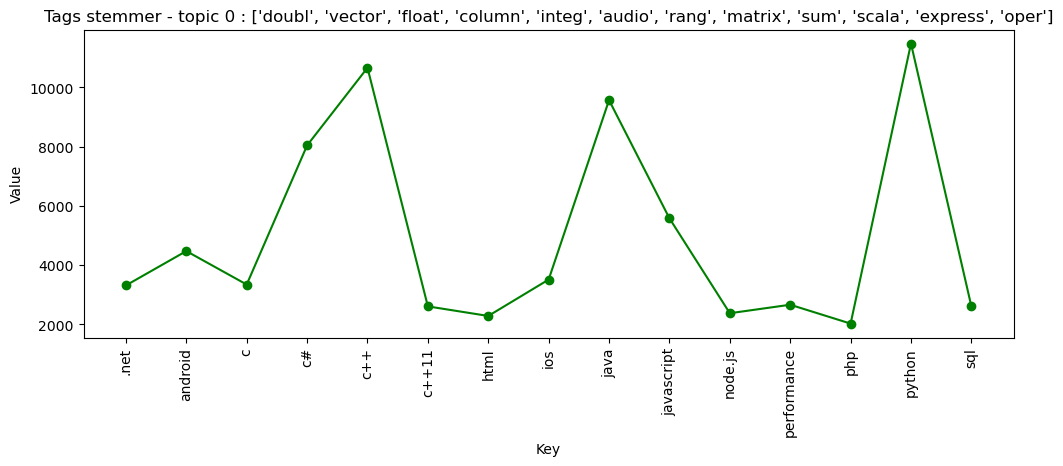



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 1 :  ['div', 'react', 'compon', 'label', 'titl', 'cell', 'swift', 'grid', 'li', 'bind', 'render', 'span'] 

word = div , df_word.shape = (10987, 11)
word = div , _Tag_1 = 4283 , _Tag_2 = 220
word = react , df_word.shape = (4978, 11)
word = react , _Tag_1 = 772 , _Tag_2 = 89
word = compon , df_word.shape = (6262, 11)
word = compon , _Tag_1 = 8582 , _Tag_2 = 5814
word = label , df_word.shape = (4800, 11)
word = label , _Tag_1 = 1237 , _Tag_2 = 296
word = titl , df_word.shape = (8496, 11)
word = titl , _Tag_1 = 673 , _Tag_2 = 10076
word = cell , df_word.shape = (2408, 11)
word = cell , _Tag_1 = 547 , _Tag_2 = 278
word = swift , df_word.shape = (3051, 11)
word = swift , _Tag_1 = 11503 , _Tag_2 = 358
word = grid , df_word.shape = (2307, 11)
word = grid , _Tag_1 = 860 , _Tag_2 = 12190
word = li , df_word.shape = (98868, 11)
word = li , _Tag_1 = 8933 , _Tag_2 = 45156
word = bind , df_

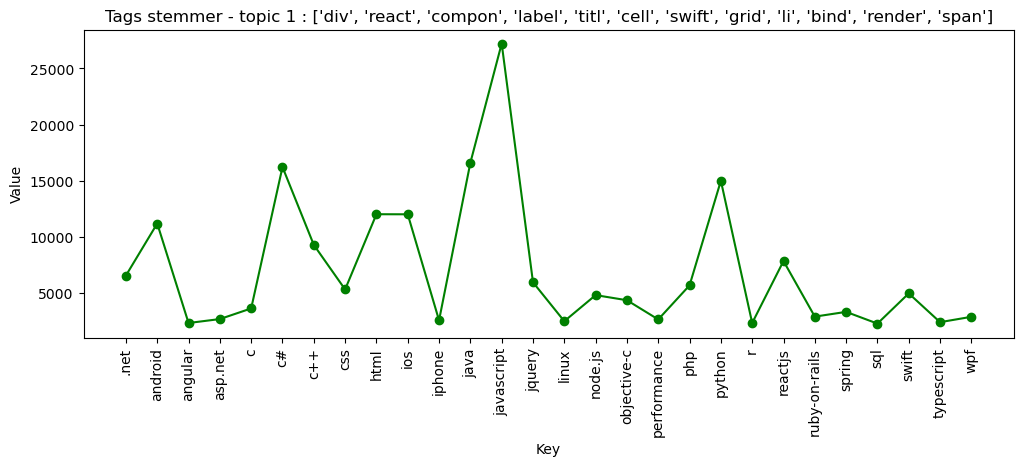



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 2 :  ['android', 'activ', 'anim', 'click', 'font', 'chrome', 'scroll', 'intent', 'overrid', 'canva', 'mobil', 'document'] 

word = android , df_word.shape = (14486, 11)
word = android , _Tag_1 = 12720 , _Tag_2 = 289
word = activ , df_word.shape = (9117, 11)
word = activ , _Tag_1 = 4737 , _Tag_2 = 148
word = anim , df_word.shape = (3543, 11)
word = anim , _Tag_1 = 2081 , _Tag_2 = 272
word = click , df_word.shape = (8817, 11)
word = click , _Tag_1 = 536 , _Tag_2 = 13019
word = font , df_word.shape = (2882, 11)
word = font , _Tag_1 = 497 , _Tag_2 = 13918
word = chrome , df_word.shape = (6233, 11)
word = chrome , _Tag_1 = 2143 , _Tag_2 = 428
word = scroll , df_word.shape = (2758, 11)
word = scroll , _Tag_1 = 5041 , _Tag_2 = 2298
word = intent , df_word.shape = (2437, 11)
word = intent , _Tag_1 = 1010 , _Tag_2 = 336
word = overrid , df_word.shape = (9165, 11)
word = overrid , _Tag_1

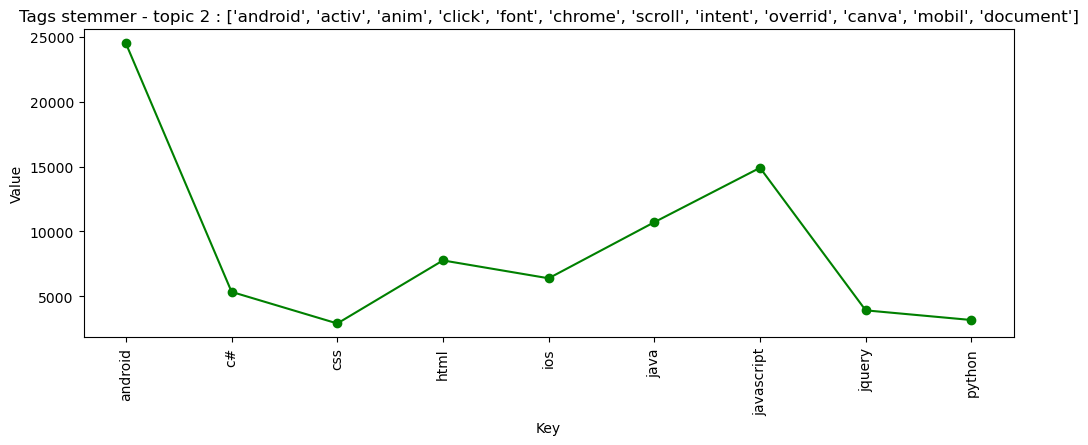



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 3 :  ['token', 'password', 'authent', 'login', 'secur', 'certif', 'train', 'author', 'account', 'plot', 'proxi', 'domain'] 

word = token , df_word.shape = (5035, 11)
word = token , _Tag_1 = 209 , _Tag_2 = 1638
word = password , df_word.shape = (7024, 11)
word = password , _Tag_1 = 1633 , _Tag_2 = 496
word = authent , df_word.shape = (5656, 11)
word = authent , _Tag_1 = 1045 , _Tag_2 = 317
word = login , df_word.shape = (5487, 11)
word = login , _Tag_1 = 684 , _Tag_2 = 266
word = secur , df_word.shape = (7033, 11)
word = secur , _Tag_1 = 1305 , _Tag_2 = 309
word = certif , df_word.shape = (2089, 11)
word = certif , _Tag_1 = 431 , _Tag_2 = 78
word = train , df_word.shape = (3794, 11)
word = train , _Tag_1 = 3793 , _Tag_2 = 166
word = author , df_word.shape = (4913, 11)
word = author , _Tag_1 = 884 , _Tag_2 = 385
word = account , df_word.shape = (3690, 11)
word = account , _Tag_1

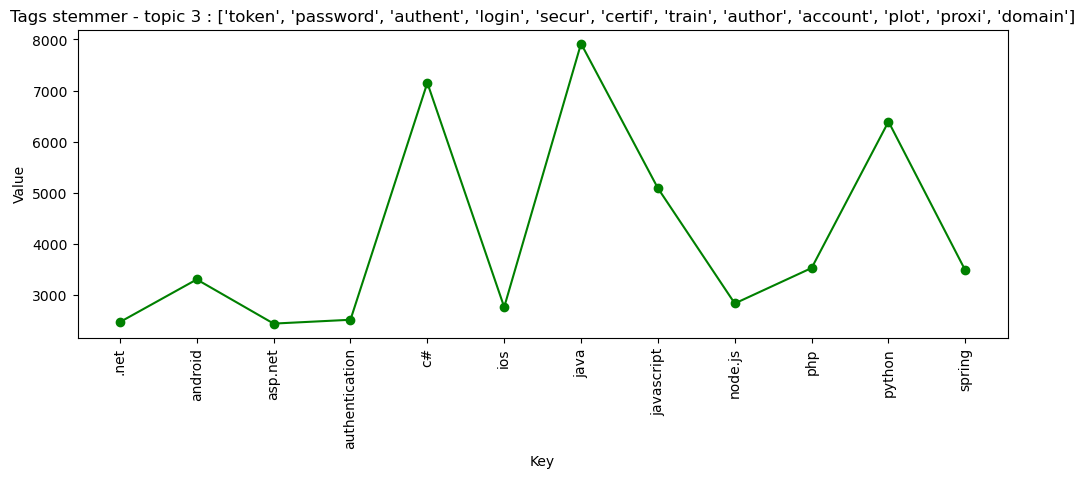



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 4 :  ['entiti', 'asp', 'git', 'control', 'column', 'session', 'valid', 'person', 'tabl', 'rout', 'repositori', 'schema'] 

word = entiti , df_word.shape = (5349, 11)
word = entiti , _Tag_1 = 526 , _Tag_2 = 199
word = asp , df_word.shape = (7744, 11)
word = asp , _Tag_1 = 5247 , _Tag_2 = 1721
word = git , df_word.shape = (4928, 11)
word = git , _Tag_1 = 278 , _Tag_2 = 160
word = control , df_word.shape = (7974, 11)
word = control , _Tag_1 = 951 , _Tag_2 = 6639
word = column , df_word.shape = (7995, 11)
word = column , _Tag_1 = 2668 , _Tag_2 = 192
word = session , df_word.shape = (6052, 11)
word = session , _Tag_1 = 575 , _Tag_2 = 10643
word = valid , df_word.shape = (5262, 11)
word = valid , _Tag_1 = 4224 , _Tag_2 = 465
word = person , df_word.shape = (2907, 11)
word = person , _Tag_1 = 1682 , _Tag_2 = 793
word = tabl , df_word.shape = (8936, 11)
word = tabl , _Tag_1 = 1462 , _T

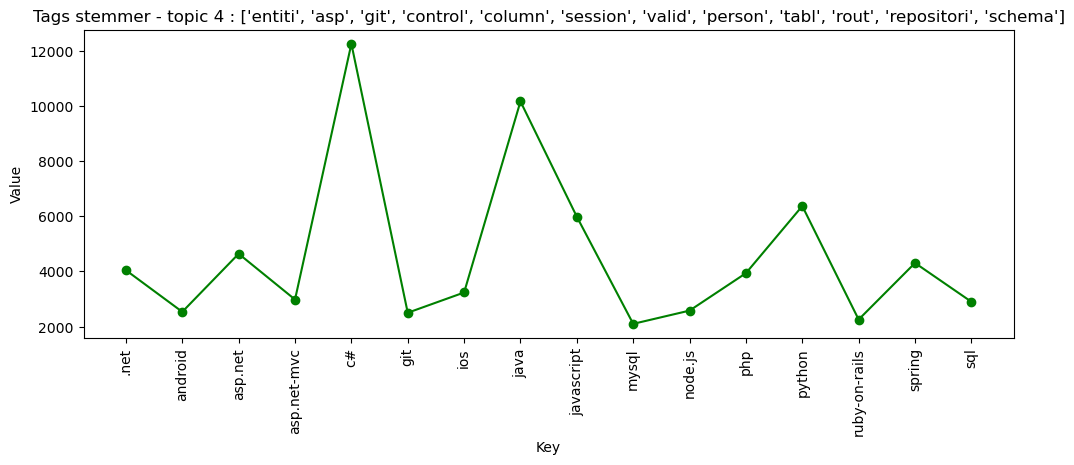



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 5 :  ['studio', 'visual', 'docker', 'angular', 'rubi', 'chrome', 'selenium', 'bash', 'browser', 'mac', 'shell', 'echo'] 

word = studio , df_word.shape = (7922, 11)
word = studio , _Tag_1 = 1851 , _Tag_2 = 126
word = visual , df_word.shape = (7201, 11)
word = visual , _Tag_1 = 234 , _Tag_2 = 36
word = docker , df_word.shape = (2165, 11)
word = docker , _Tag_1 = 309 , _Tag_2 = 46
word = angular , df_word.shape = (4145, 11)
word = angular , _Tag_1 = 1566 , _Tag_2 = 102
word = rubi , df_word.shape = (2827, 11)
word = rubi , _Tag_1 = 1535 , _Tag_2 = 1557
word = chrome , df_word.shape = (6233, 11)
word = chrome , _Tag_1 = 1420 , _Tag_2 = 291
word = selenium , df_word.shape = (1496, 11)
word = selenium , _Tag_1 = 1953 , _Tag_2 = 939
word = bash , df_word.shape = (2317, 11)
word = bash , _Tag_1 = 1011 , _Tag_2 = 266
word = browser , df_word.shape = (8799, 11)
word = browser , _Tag_1 =

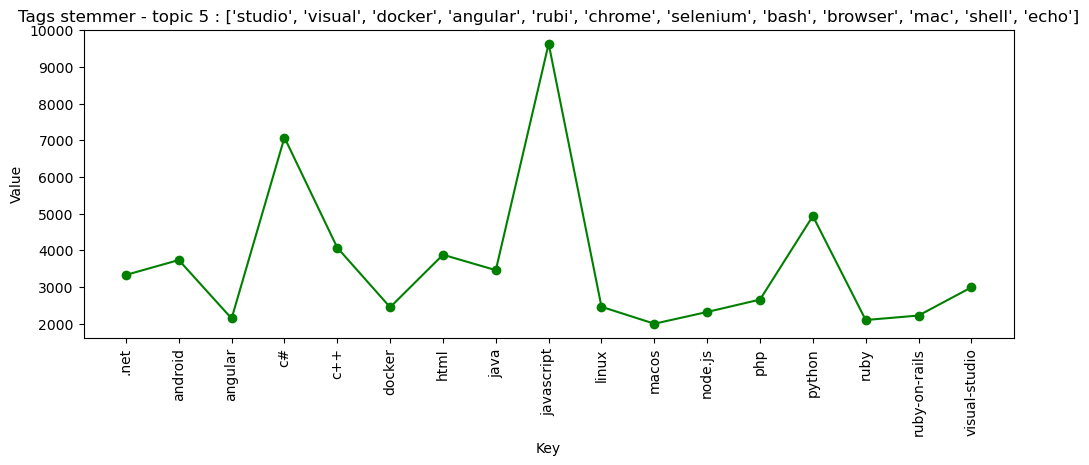



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 6 :  ['char', 'assembl', 'boost', 'oper', 'gener', 'lock', 'pointer', 'queue', 'clang', 'await', 'link', 'free'] 

word = char , df_word.shape = (6521, 11)
word = char , _Tag_1 = 239 , _Tag_2 = 9
word = assembl , df_word.shape = (3605, 11)
word = assembl , _Tag_1 = 2733 , _Tag_2 = 505
word = boost , df_word.shape = (1622, 11)
word = boost , _Tag_1 = 4103 , _Tag_2 = 465
word = oper , df_word.shape = (12292, 11)
word = oper , _Tag_1 = 2167 , _Tag_2 = 431
word = gener , df_word.shape = (12765, 11)
word = gener , _Tag_1 = 379 , _Tag_2 = 12686
word = lock , df_word.shape = (5934, 11)
word = lock , _Tag_1 = 4766 , _Tag_2 = 1154
word = pointer , df_word.shape = (3331, 11)
word = pointer , _Tag_1 = 10037 , _Tag_2 = 15647
word = queue , df_word.shape = (2454, 11)
word = queue , _Tag_1 = 2442 , _Tag_2 = 634
word = clang , df_word.shape = (2237, 11)
word = clang , _Tag_1 = 636 , _Tag_2 = 

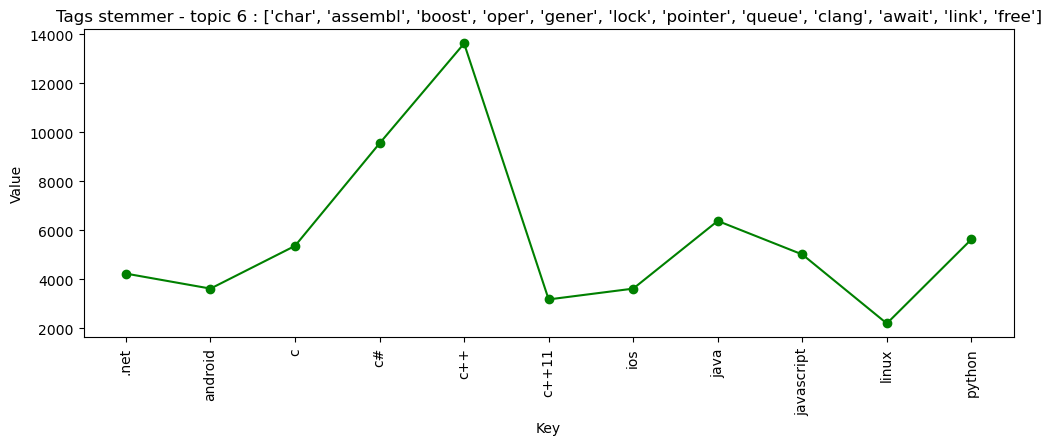



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 7 :  ['spring', 'eclips', 'jar', 'apach', 'hibern', 'boot', 'depend', 'bean', 'annot', 'mock', 'tomcat', 'sun'] 

word = spring , df_word.shape = (6634, 11)
word = spring , _Tag_1 = 4796 , _Tag_2 = 24
word = eclips , df_word.shape = (3357, 11)
word = eclips , _Tag_1 = 6775 , _Tag_2 = 309
word = jar , df_word.shape = (3631, 11)
word = jar , _Tag_1 = 1490 , _Tag_2 = 252
word = apach , df_word.shape = (4944, 11)
word = apach , _Tag_1 = 11582 , _Tag_2 = 1146
word = hibern , df_word.shape = (2580, 11)
word = hibern , _Tag_1 = 1435 , _Tag_2 = 269
word = boot , df_word.shape = (6094, 11)
word = boot , _Tag_1 = 2637 , _Tag_2 = 5575
word = depend , df_word.shape = (9300, 11)
word = depend , _Tag_1 = 331 , _Tag_2 = 112
word = bean , df_word.shape = (2467, 11)
word = bean , _Tag_1 = 19311 , _Tag_2 = 1746
word = annot , df_word.shape = (3161, 11)
word = annot , _Tag_1 = 3062 , _Tag_2 = 474

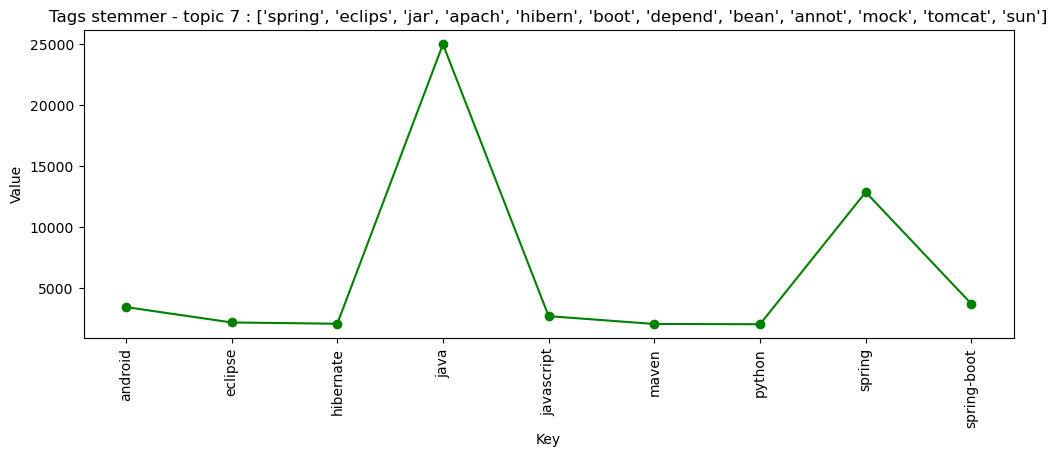

In [186]:
# graphique
graphique_topic_modeling_with_LDA(normalization_type_in = 'stemmer', 
                                  num_word_per_topic_in = 12, 
                                  lda_components_in     = lda_components_stemmer, 
                                  terms_in              = terms_stemmer)

In [ ]:
##################################################################
# ANALYSE GRAPHIQUE STEMMER :                                    #
# Synthèse des 5 premiers tags fournis par LDA pour chaque topic #
##################################################################
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 0 :  ['doubl', 'vector', 'float', 'column', 'integ', 'audio', 'rang', 'matrix', 'sum', 'scala', 'express', 'oper'] 
#
# ('python',     11482)
# ('c++',        10666)
# ('java',        9573)
# ('c#',          8045)
# ('javascript',  5584)
#
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 1 :  ['div', 'react', 'compon', 'label', 'titl', 'cell', 'swift', 'grid', 'li', 'bind', 'render', 'span'] 
#
# ('javascript', 27215)
# ('java',       16609)
# ('c#',         16225)
# ('python',     15002)
# ('html',       12023)
#
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 2 :  ['android', 'activ', 'anim', 'click', 'font', 'chrome', 'scroll', 'intent', 'overrid', 'canva', 'mobil', 
#             'document'] 
#
# ('android',    24496)
# ('javascript', 14907)
# ('java',       10711)
# ('html',        7763)
# ('ios',         6385)
# 
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 3 :  ['token', 'password', 'authent', 'login', 'secur', 'certif', 'train', 'author', 'account', 'plot', 'proxi',
#             'domain'] 
#
# ('java',       7918)
# ('c#',         7150)
# ('python',     6391)
# ('javascript', 5088)
# ('php',        3527)
#
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 4 :  ['entiti', 'asp', 'git', 'control', 'column', 'session', 'valid', 'person', 'tabl', 'rout', 'repositori',
#             'schema'] 
#
# ('c#',        12242)
# ('java',      10155)
# ('python',     6365)
# ('javascript', 5978)
# ('asp.net',    4636)
# 
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 5 :  ['studio', 'visual', 'docker', 'angular', 'rubi', 'chrome', 'selenium', 'bash', 'browser', 'mac', 'shell',
#             'echo'] 
#
# ('javascript', 9629)
# ('c#',         7074)
# ('python',     4935)
# ('c++',        4073)
# ('html',       3881)
#
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 6 :  ['char', 'assembl', 'boost', 'oper', 'gener', 'lock', 'pointer', 'queue', 'clang', 'await', 'link', 'free'] 
#
# ('c++',   13622)
# ('c#',     9548)
# ('java',   6385)
# ('python', 5633)
# ('c',      5367)
#
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 7 :  ['spring', 'eclips', 'jar', 'apach', 'hibern', 'boot', 'depend', 'bean', 'annot', 'mock', 'tomcat', 'sun'] 
#
# ('java',        25012)
# ('spring',      12872)
# ('spring-boot',  3703)
# ('android',      3438)
# ('javascript',   2693)

In [ ]:
####################################
# LDA corpus lemma                 #
####################################

In [179]:
lda_components_lemma, terms_lemma = topic_modeling_with_LDA(normalization_type_in = 'lemma',
                                                            num_components_in     = 8, 
                                                            num_word_per_topic_in = 12, 
                                                            tfidfvectorizer_in    = tfidfvectorizer_lemma, 
                                                            train_data_in         = train_data_lemma) # 6 min

Topic 0 :  ['token', 'password', 'asp', 'session', 'login', 'authentication', 'spring', 'security', 'visual', 'studio', 'certificate', 'controller']
Topic 1 :  ['matrix', 'float', 'double', 'plot', 'range', 'vector', 'sum', 'shape', 'algorithm', 'spark', 'train', 'column']
Topic 2 :  ['git', 'chrome', 'apache', 'eclipse', 'browser', 'jar', 'ruby', 'selenium', 'site', 'driver', 'dependency', 'remote']
Topic 3 :  ['char', 'pointer', 'operator', 'clang', 'boost', 'expression', 'constructor', 'vector', 'member', 'bool', 'assembly', 'generic']
Topic 4 :  ['div', 'font', 'swift', 'cell', 'click', 'scroll', 'grid', 'label', 'binding', 'title', 'nil', 'menu']
Topic 5 :  ['android', 'docker', 'play', 'audio', 'activity', 'intent', 'studio', 'camera', 'player', 'phone', 'permission', 'emulator']
Topic 6 :  ['column', 'entity', 'hibernate', 'spring', 'div', 'schema', 'product', 'person', 'validation', 'table', 'group', 'annotation']
Topic 7 :  ['react', 'angular', 'component', 'mock', 'export', '

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)




 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 0 :  ['token', 'password', 'asp', 'session', 'login', 'authentication', 'spring', 'security', 'visual', 'studio', 'certificate', 'controller'] 

word = token , df_word.shape = (5035, 11)
word = token , _Tag_1 = 209 , _Tag_2 = 1638
word = password , df_word.shape = (7024, 11)
word = password , _Tag_1 = 1633 , _Tag_2 = 496
word = asp , df_word.shape = (7744, 11)
word = asp , _Tag_1 = 5294 , _Tag_2 = 1664
word = session , df_word.shape = (6054, 11)
word = session , _Tag_1 = 188 , _Tag_2 = 7043
word = login , df_word.shape = (5487, 11)
word = login , _Tag_1 = 659 , _Tag_2 = 273
word = authentication , df_word.shape = (4645, 11)
word = authentication , _Tag_1 = 1798 , _Tag_2 = 438
word = spring , df_word.shape = (6637, 11)
word = spring , _Tag_1 = 9422 , _Tag_2 = 159
word = security , df_word.shape = (5465, 11)
word = security , _Tag_1 = 1760 , _Tag_2 = 469
word = visual , df_word.s

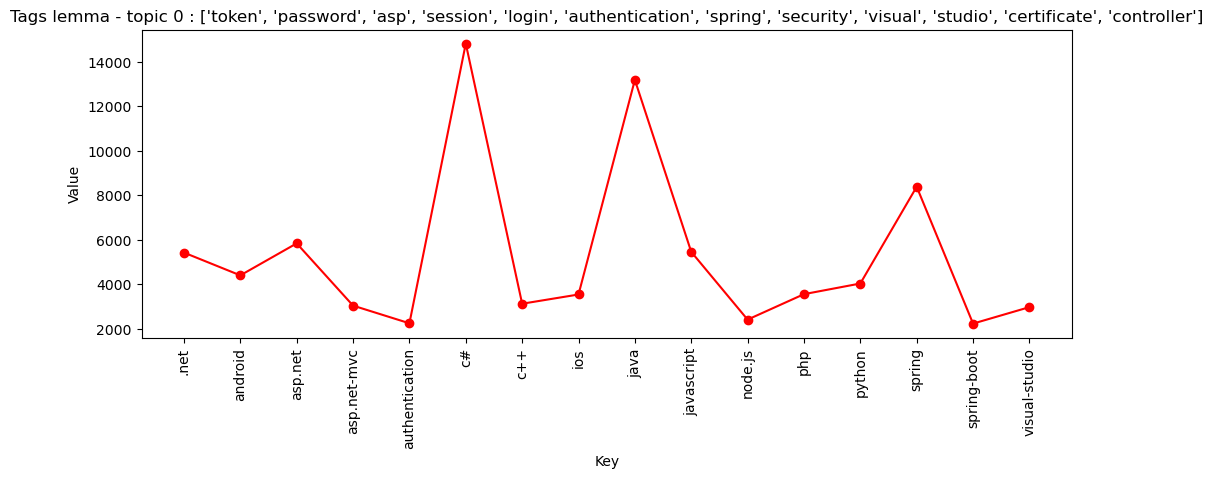



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 1 :  ['matrix', 'float', 'double', 'plot', 'range', 'vector', 'sum', 'shape', 'algorithm', 'spark', 'train', 'column'] 

word = matrix , df_word.shape = (2197, 11)
word = matrix , _Tag_1 = 114 , _Tag_2 = 283
word = float , df_word.shape = (4009, 11)
word = float , _Tag_1 = 1712 , _Tag_2 = 2380
word = double , df_word.shape = (4515, 11)
word = double , _Tag_1 = 1186 , _Tag_2 = 824
word = plot , df_word.shape = (2209, 11)
word = plot , _Tag_1 = 952 , _Tag_2 = 5188
word = range , df_word.shape = (8336, 11)
word = range , _Tag_1 = 5719 , _Tag_2 = 966
word = vector , df_word.shape = (3219, 11)
word = vector , _Tag_1 = 1366 , _Tag_2 = 1174
word = sum , df_word.shape = (14088, 11)
word = sum , _Tag_1 = 1943 , _Tag_2 = 583
word = shape , df_word.shape = (2540, 11)
word = shape , _Tag_1 = 4012 , _Tag_2 = 15122
word = algorithm , df_word.shape = (3436, 11)
word = algorithm , _Tag_1 = 102

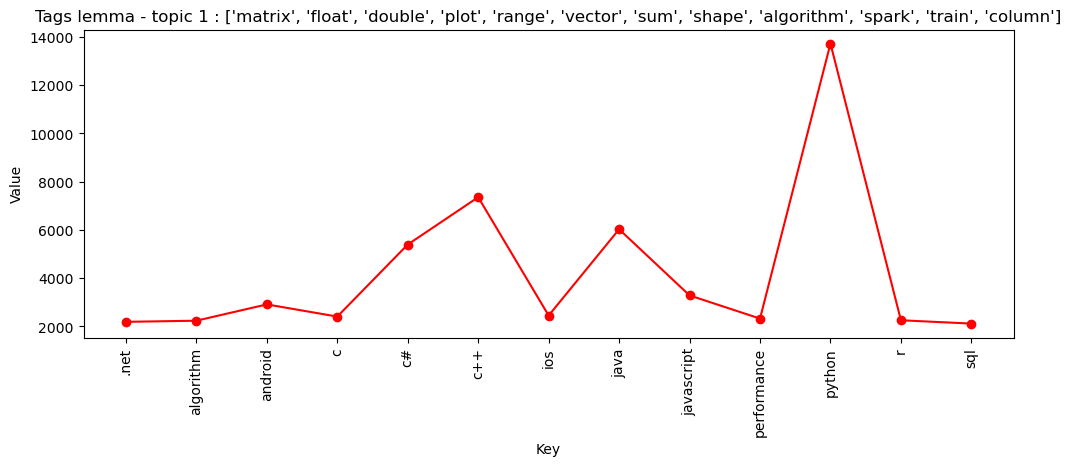



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 2 :  ['git', 'chrome', 'apache', 'eclipse', 'browser', 'jar', 'ruby', 'selenium', 'site', 'driver', 'dependency', 'remote'] 

word = git , df_word.shape = (4928, 11)
word = git , _Tag_1 = 206 , _Tag_2 = 128
word = chrome , df_word.shape = (6256, 11)
word = chrome , _Tag_1 = 849 , _Tag_2 = 238
word = apache , df_word.shape = (4944, 11)
word = apache , _Tag_1 = 3051 , _Tag_2 = 508
word = eclipse , df_word.shape = (3357, 11)
word = eclipse , _Tag_1 = 5030 , _Tag_2 = 709
word = browser , df_word.shape = (8799, 11)
word = browser , _Tag_1 = 530 , _Tag_2 = 399
word = jar , df_word.shape = (3631, 11)
word = jar , _Tag_1 = 2982 , _Tag_2 = 305
word = ruby , df_word.shape = (2827, 11)
word = ruby , _Tag_1 = 1978 , _Tag_2 = 1810
word = selenium , df_word.shape = (1496, 11)
word = selenium , _Tag_1 = 2603 , _Tag_2 = 1220
word = site , df_word.shape = (8813, 11)
word = site , _Tag_1 = 2294 

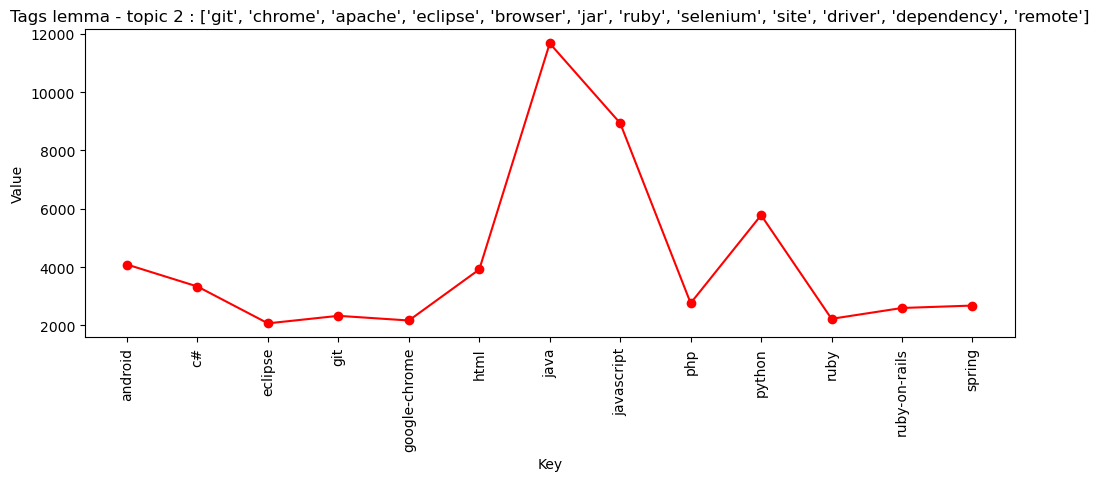



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 3 :  ['char', 'pointer', 'operator', 'clang', 'boost', 'expression', 'constructor', 'vector', 'member', 'bool', 'assembly', 'generic'] 

word = char , df_word.shape = (6521, 11)
word = char , _Tag_1 = 239 , _Tag_2 = 9
word = pointer , df_word.shape = (3331, 11)
word = pointer , _Tag_1 = 3802 , _Tag_2 = 3365
word = operator , df_word.shape = (2755, 11)
word = operator , _Tag_1 = 5282 , _Tag_2 = 4400
word = clang , df_word.shape = (2237, 11)
word = clang , _Tag_1 = 83 , _Tag_2 = 74
word = boost , df_word.shape = (1622, 11)
word = boost , _Tag_1 = 8256 , _Tag_2 = 681
word = expression , df_word.shape = (3274, 11)
word = expression , _Tag_1 = 1335 , _Tag_2 = 26
word = constructor , df_word.shape = (5226, 11)
word = constructor , _Tag_1 = 10038 , _Tag_2 = 8454
word = vector , df_word.shape = (3219, 11)
word = vector , _Tag_1 = 1979 , _Tag_2 = 766
word = member , df_word.shape = (428

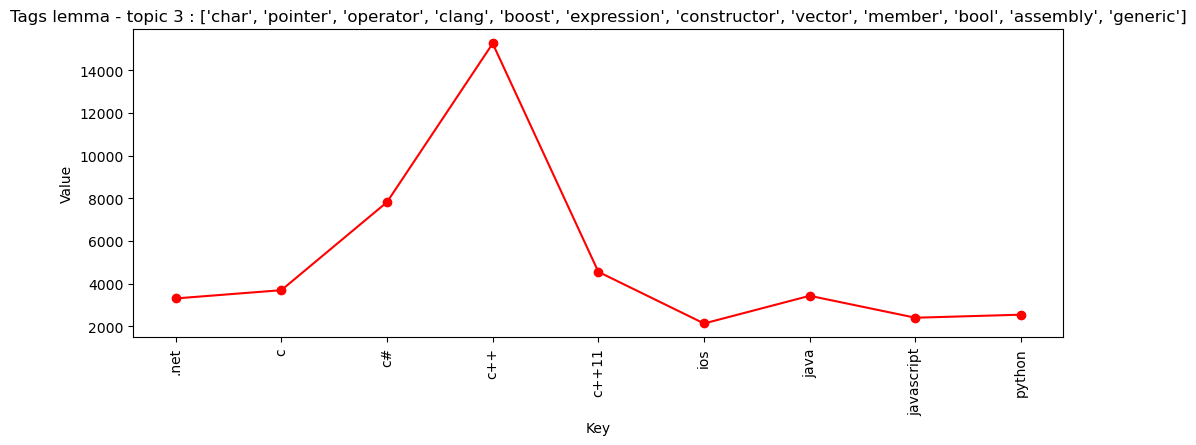



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 4 :  ['div', 'font', 'swift', 'cell', 'click', 'scroll', 'grid', 'label', 'binding', 'title', 'nil', 'menu'] 

word = div , df_word.shape = (10987, 11)
word = div , _Tag_1 = 4283 , _Tag_2 = 220
word = font , df_word.shape = (2882, 11)
word = font , _Tag_1 = 793 , _Tag_2 = 3390
word = swift , df_word.shape = (3051, 11)
word = swift , _Tag_1 = 4944 , _Tag_2 = 185
word = cell , df_word.shape = (2946, 11)
word = cell , _Tag_1 = 261 , _Tag_2 = 143
word = click , df_word.shape = (8817, 11)
word = click , _Tag_1 = 378 , _Tag_2 = 7188
word = scroll , df_word.shape = (2758, 11)
word = scroll , _Tag_1 = 5772 , _Tag_2 = 2583
word = grid , df_word.shape = (2307, 11)
word = grid , _Tag_1 = 462 , _Tag_2 = 8922
word = label , df_word.shape = (4800, 11)
word = label , _Tag_1 = 5492 , _Tag_2 = 3183
word = binding , df_word.shape = (3155, 11)
word = binding , _Tag_1 = 3009 , _Tag_2 = 70
word = t

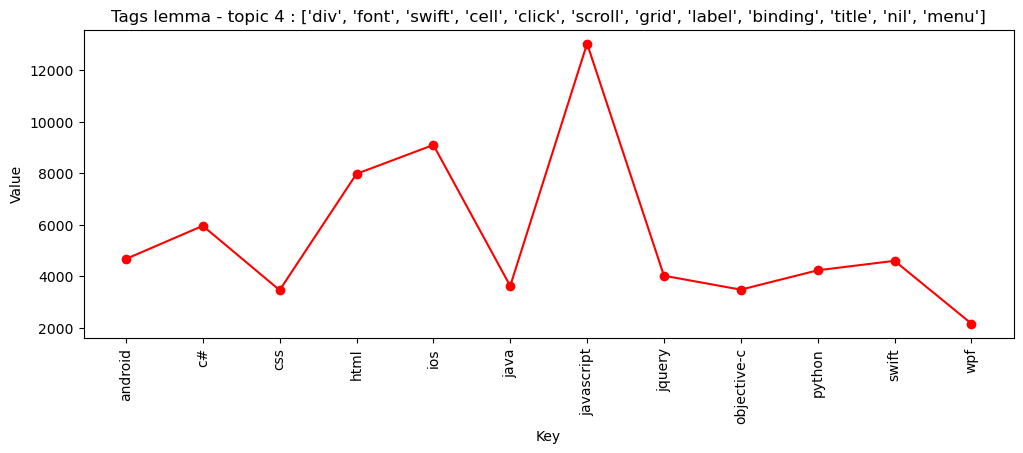



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 5 :  ['android', 'docker', 'play', 'audio', 'activity', 'intent', 'studio', 'camera', 'player', 'phone', 'permission', 'emulator'] 

word = android , df_word.shape = (14486, 11)
word = android , _Tag_1 = 12720 , _Tag_2 = 289
word = docker , df_word.shape = (2165, 11)
word = docker , _Tag_1 = 274 , _Tag_2 = 81
word = play , df_word.shape = (7836, 11)
word = play , _Tag_1 = 14452 , _Tag_2 = 381
word = audio , df_word.shape = (1721, 11)
word = audio , _Tag_1 = 2215 , _Tag_2 = 126
word = activity , df_word.shape = (3891, 11)
word = activity , _Tag_1 = 17939 , _Tag_2 = 405
word = intent , df_word.shape = (2437, 11)
word = intent , _Tag_1 = 525 , _Tag_2 = 141
word = studio , df_word.shape = (7922, 11)
word = studio , _Tag_1 = 21321 , _Tag_2 = 545
word = camera , df_word.shape = (1512, 11)
word = camera , _Tag_1 = 21850 , _Tag_2 = 547
word = player , df_word.shape = (1271, 11)
word = 

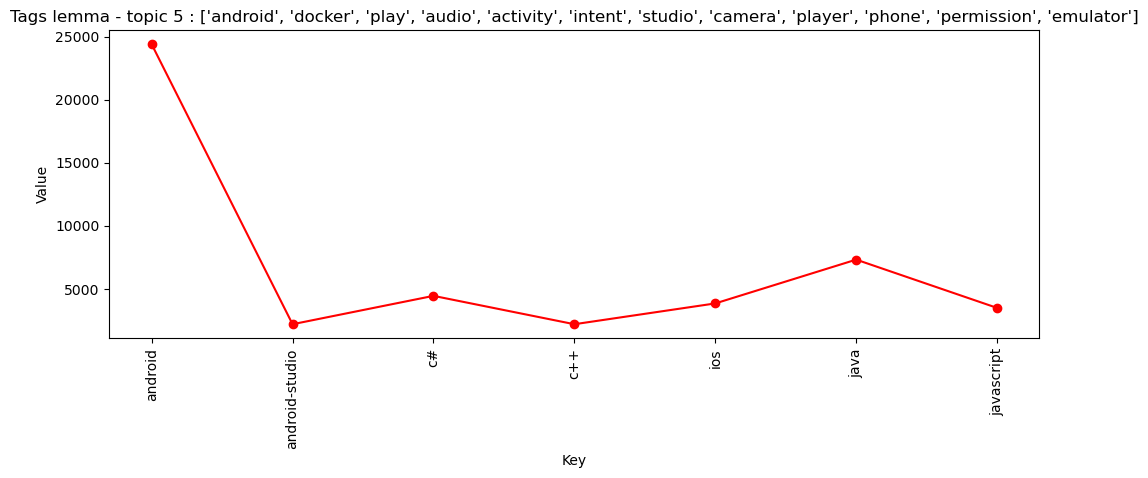



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 6 :  ['column', 'entity', 'hibernate', 'spring', 'div', 'schema', 'product', 'person', 'validation', 'table', 'group', 'annotation'] 

word = column , df_word.shape = (7995, 11)
word = column , _Tag_1 = 1820 , _Tag_2 = 72
word = entity , df_word.shape = (7230, 11)
word = entity , _Tag_1 = 813 , _Tag_2 = 286
word = hibernate , df_word.shape = (2577, 11)
word = hibernate , _Tag_1 = 1744 , _Tag_2 = 427
word = spring , df_word.shape = (6637, 11)
word = spring , _Tag_1 = 9660 , _Tag_2 = 92
word = div , df_word.shape = (10987, 11)
word = div , _Tag_1 = 5017 , _Tag_2 = 398
word = schema , df_word.shape = (3057, 11)
word = schema , _Tag_1 = 3159 , _Tag_2 = 8122
word = product , df_word.shape = (5915, 11)
word = product , _Tag_1 = 738 , _Tag_2 = 10153
word = person , df_word.shape = (2907, 11)
word = person , _Tag_1 = 1162 , _Tag_2 = 514
word = validation , df_word.shape = (3140, 11)
wo

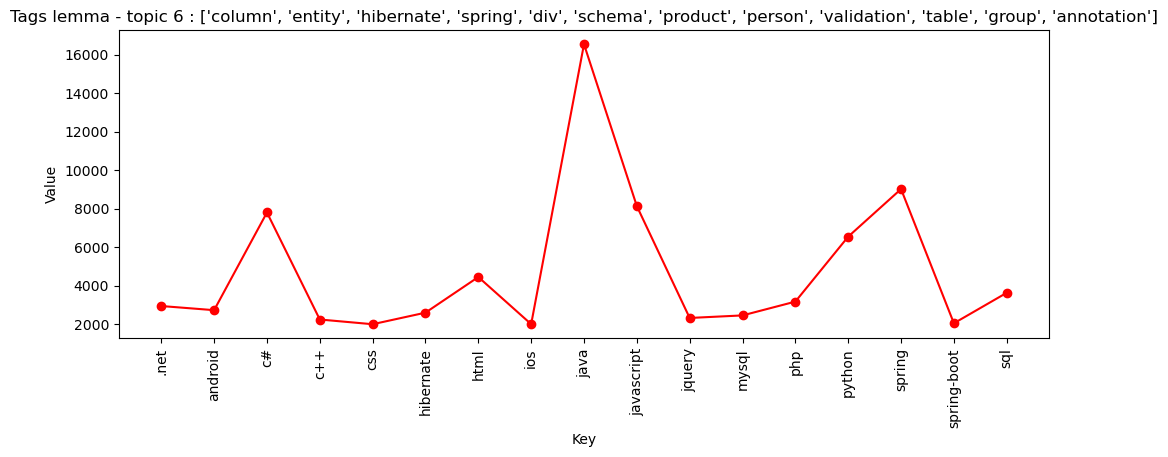



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 7 :  ['react', 'angular', 'component', 'mock', 'export', 'typescript', 'err', 'prop', 'loader', 'fragment', 'router', 'div'] 

word = react , df_word.shape = (4978, 11)
word = react , _Tag_1 = 207 , _Tag_2 = 25
word = angular , df_word.shape = (4145, 11)
word = angular , _Tag_1 = 1516 , _Tag_2 = 137
word = component , df_word.shape = (6261, 11)
word = component , _Tag_1 = 5989 , _Tag_2 = 4164
word = mock , df_word.shape = (2160, 11)
word = mock , _Tag_1 = 335 , _Tag_2 = 94
word = export , df_word.shape = (5209, 11)
word = export , _Tag_1 = 225 , _Tag_2 = 6185
word = typescript , df_word.shape = (1651, 11)
word = typescript , _Tag_1 = 3477 , _Tag_2 = 6530
word = err , df_word.shape = (15731, 11)
word = err , _Tag_1 = 1989 , _Tag_2 = 887
word = prop , df_word.shape = (8993, 11)
word = prop , _Tag_1 = 1743 , _Tag_2 = 15047
word = loader , df_word.shape = (1950, 11)
word = loader ,

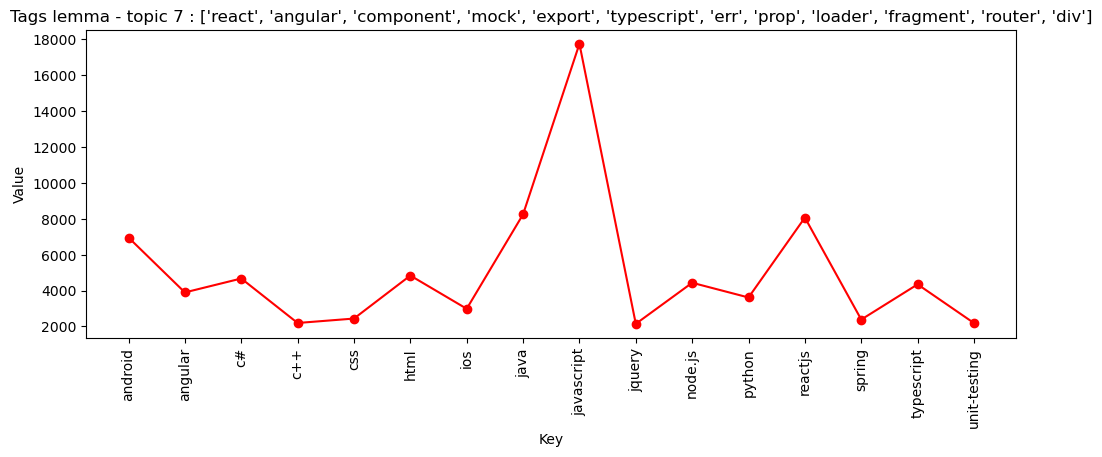

In [187]:
# graphique
graphique_topic_modeling_with_LDA(normalization_type_in = 'lemma', 
                                  num_word_per_topic_in = 12, 
                                  lda_components_in     = lda_components_lemma, 
                                  terms_in              = terms_lemma)

In [ ]:
##################################################################
# ANALYSE GRAPHIQUE LEMMA :                                      #
# Synthèse des 5 premiers tags fournis par LDA pour chaque topic #
##################################################################
#
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 0 :  ['token', 'password', 'asp', 'session', 'login', 'authentication', 'spring', 'security', 'visual', 'studio',
#             'certificate', 'controller'] 
# 
# ('c#',        14811)
# ('java',      13179)
# ('spring',     8377)
# ('asp.net',    5832)
# ('javascript', 5451) 
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 1 :  ['matrix', 'float', 'double', 'plot', 'range', 'vector', 'sum', 'shape', 'algorithm', 'spark', 'train', 
#             'column'] 
# 
# ('python',   13722)
# ('c++',       7357)
# ('java',       6028)
# ('c#',         5395)
# ('javascript', 3287)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 2 :  ['git', 'chrome', 'apache', 'eclipse', 'browser', 'jar', 'ruby', 'selenium', 'site', 'driver', 'dependency', 
#             'remote'] 
# 
# ('java',       11671)
# ('javascript',  8933)
# ('python',      5778)
# ('android',     4085)
# ('html',        3917)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 3 :  ['char', 'pointer', 'operator', 'clang', 'boost', 'expression', 'constructor', 'vector', 'member', 'bool', 
#             'assembly', 'generic'] 
# 
# ('c++',   15251)
# ('c#',     7817)
# ('c++11',  4549)
# ('c',      3690)
# ('java',   3427)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 4 :  ['div', 'font', 'swift', 'cell', 'click', 'scroll', 'grid', 'label', 'binding', 'title', 'nil', 'menu'] 
# 
# ('javascript', 13034)
# ('ios',         9095)
# ('html',        7972)
# ('c#',          5953)
# ('android',     4665)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 5 :  ['android', 'docker', 'play', 'audio', 'activity', 'intent', 'studio', 'camera', 'player', 'phone', 
#            'permission', 'emulator'] 
# 
# ('android',   24395)
# ('java',       7321)
# ('c#',         4449)
# ('ios',        3850)
# ('javascript', 3494)
# 
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 6 :  ['column', 'entity', 'hibernate', 'spring', 'div', 'schema', 'product', 'person', 'validation', 'table', 
#             'group', 'annotation'] 
# 
# ('java',       16535)
# ('spring',      9020)
# ('javascript',  8134)
# ('c#',          7804)
# ('python',      6551)
#  
# 
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Topic 7 :  ['react', 'angular', 'component', 'mock', 'export', 'typescript', 'err', 'prop', 'loader', 'fragment', 
#             'router', 'div'] 
# 
# ('javascript', 17751)
# ('java',        8246)
# ('reactjs',     8065)
# ('android',     6952)
# ('html',        4834)

In [ ]:
# => la pertinence du machine learning non supervisé est plutôt globale et imprécise.

# 2.2.2. METHODE 2

In [ ]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# Topic model : LDA
# ------------------------------------------------
# 1) Data transformation: Corpus and Dictionary
# 2) Base Model
# 3) Hyperparameter Tuning
# 4) Final Model
# 5) Visualize Results

In [13]:
#####################################################
#  1) Data Transformation : Corpus and Dictionary   #
#####################################################
# https://stackoverflow.com/questions/33229360/gensim-typeerror-doc2bow-expects-an-array-of-unicode-tokens-on-input-not-a-si
# The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.
def LDA_Data_Transformation(normalization_type_in, corpus_liste_in):
       
    # Create Dictionary
    id2word = corpora.Dictionary(corpus_liste_in)

    # Create Corpus
    texts = corpus_liste_in

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # View
    print('Term Document Frequency for', normalization_type_in, ':', corpus[:1][0][:30])
    
    return id2word, texts, corpus

In [14]:
# corpus_lemma = ' '.join(df['_Lemma_clean'])
id2word_lemma, texts_lemma, corpus_lemma = LDA_Data_Transformation(normalization_type_in = 'lemma',
                                                                   corpus_liste_in       = [token_lemma])

Term Document Frequency for lemma : [(0, 837), (1, 15), (2, 15), (3, 73), (4, 837), (5, 36), (6, 18), (7, 3), (8, 3), (9, 126), (10, 136), (11, 9), (12, 2), (13, 22), (14, 9), (15, 2), (16, 4), (17, 2), (18, 7), (19, 62), (20, 2), (21, 14), (22, 2), (23, 9), (24, 2), (25, 3), (26, 4), (27, 2), (28, 2), (29, 19)]


In [15]:
# corpus_stemmer = ' '.join(df['_Stemmer_clean'])
id2word_stemmer, texts_stemmer, corpus_stemmer = LDA_Data_Transformation(normalization_type_in = 'stemmer',
                                                                         corpus_liste_in       = [token_stemmer])

Term Document Frequency for stemmer : [(0, 837), (1, 15), (2, 15), (3, 73), (4, 837), (5, 36), (6, 18), (7, 3), (8, 3), (9, 262), (10, 9), (11, 2), (12, 22), (13, 11), (14, 4), (15, 2), (16, 2), (17, 69), (18, 16), (19, 9), (20, 2), (21, 7), (22, 2), (23, 2), (24, 6), (25, 25), (26, 3), (27, 1395), (28, 128), (29, 16)]


In [16]:
#####################################################
# 2) Base Model                                     #
#####################################################
def LDA_Base_Model(normalization_type_in, corpus_in, id2word_in):
    
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus          = corpus_in,
                                           id2word         = id2word_in,
                                           num_topics      = 10, 
                                           random_state    = 100,
                                           chunksize       = 100,
                                           passes          = 10,
                                           per_word_topics = True)

    # View the topics in LDA model
    # Print the Keyword in the 10 topics
    print('10 topics in LDA model for', normalization_type_in, ':')
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus_in]
    
    return lda_model

In [18]:
lda_model_lemma = LDA_Base_Model(normalization_type_in = 'lemma',
                                 corpus_in             = corpus_lemma,
                                 id2word_in            = id2word_lemma)

10 topics in LDA model for lemma :
[(0,
  '0.021*"android" + 0.007*"div" + 0.005*"spring" + 0.005*"apache" + '
  '0.004*"override" + 0.004*"jar" + 0.004*"component" + 0.004*"column" + '
  '0.004*"site" + 0.003*"security"'),
 (1,
  '0.016*"android" + 0.007*"div" + 0.005*"apache" + 0.005*"spring" + '
  '0.004*"site" + 0.004*"jar" + 0.004*"react" + 0.003*"release" + '
  '0.003*"browser" + 0.003*"label"'),
 (2,
  '0.020*"android" + 0.007*"div" + 0.006*"apache" + 0.005*"spring" + '
  '0.004*"jar" + 0.004*"title" + 0.004*"session" + 0.004*"override" + '
  '0.003*"dependency" + 0.003*"security"'),
 (3,
  '0.022*"android" + 0.008*"div" + 0.005*"apache" + 0.004*"jar" + '
  '0.004*"password" + 0.004*"action" + 0.004*"column" + 0.003*"title" + '
  '0.003*"spring" + 0.003*"final"'),
 (4,
  '0.019*"android" + 0.006*"div" + 0.005*"spring" + 0.004*"session" + '
  '0.004*"react" + 0.004*"jar" + 0.004*"apache" + 0.003*"controller" + '
  '0.003*"security" + 0.003*"title"'),
 (5,
  '0.025*"android" + 0.0

In [19]:
lda_model_stemmer = LDA_Base_Model(normalization_type_in = 'stemmer',
                                   corpus_in             = corpus_stemmer,
                                   id2word_in            = id2word_stemmer)

10 topics in LDA model for stemmer :
[(0,
  '0.021*"android" + 0.007*"div" + 0.006*"jar" + 0.005*"apach" + 0.004*"activ" '
  '+ 0.004*"password" + 0.004*"token" + 0.004*"session" + 0.004*"titl" + '
  '0.004*"secur"'),
 (1,
  '0.023*"android" + 0.008*"div" + 0.005*"jar" + 0.004*"apach" + '
  '0.004*"spring" + 0.004*"activ" + 0.004*"depend" + 0.004*"releas" + '
  '0.003*"password" + 0.003*"react"'),
 (2,
  '0.018*"android" + 0.007*"div" + 0.006*"apach" + 0.005*"spring" + '
  '0.005*"final" + 0.005*"jar" + 0.004*"activ" + 0.004*"column" + 0.003*"site" '
  '+ 0.003*"action"'),
 (3,
  '0.021*"android" + 0.009*"div" + 0.005*"apach" + 0.004*"secur" + '
  '0.004*"spring" + 0.004*"activ" + 0.004*"jar" + 0.004*"control" + '
  '0.003*"final" + 0.003*"product"'),
 (4,
  '0.021*"android" + 0.009*"div" + 0.005*"apach" + 0.005*"jar" + 0.004*"final" '
  '+ 0.004*"secur" + 0.004*"activ" + 0.004*"spring" + 0.004*"session" + '
  '0.004*"site"'),
 (5,
  '0.014*"android" + 0.006*"div" + 0.006*"spring" + 0.

In [51]:
####################################################
#   Compute Model Perplexity and Coherence Score   #
####################################################
def LDA_Coherence_Score(normalization_type_in, lda_model_in, corpus_liste_in, id2word_in):
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model      = lda_model_in, 
                                         texts      = corpus_liste_in, 
                                         dictionary = id2word_in, 
                                         coherence  = 'c_v')

    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score for', normalization_type_in, ':', coherence_lda)

In [26]:
LDA_Coherence_Score(normalization_type_in = 'lemma',
                    lda_model_in          = lda_model_lemma, 
                    corpus_liste_in       = [token_lemma], 
                    id2word_in            = id2word_lemma)

Coherence Score for lemma : 0.3067311449555698


In [52]:
LDA_Coherence_Score(normalization_type_in = 'stemmer',
                    lda_model_in          = lda_model_stemmer, 
                    corpus_liste_in       = [token_stemmer], 
                    id2word_in            = id2word_stemmer)

Coherence Score for stemmer : 0.29796233974032593


In [ ]:
#####################################################
# 3) Hyperparameter Tuning                          #
#####################################################
#   --> k : Number of Topics
#   --> a (Dirichlet hyperparameter alpha) : Document-Topic Density
#   --> b (Dirichlet hyperparameter beta) : Word-Topic Density

In [20]:
# supporting function
def compute_coherence_values(corpus_in, id2word_in, k_in, a_in, b_in, lda_model_in, corpus_liste_in):
    
    lda_model = gensim.models.LdaMulticore(corpus       = corpus_in,
                                           id2word      = id2word_in,
                                           num_topics   = k_in, 
                                           random_state = 100,
                                           chunksize    = 100,
                                           passes       = 10,
                                           alpha        = a_in,
                                           eta          = b_in)
    
    coherence_model_lda = CoherenceModel(model      = lda_model_in,
                                         texts      = corpus_liste_in,
                                         dictionary = id2word_in, 
                                         coherence  = 'c_v')
    
    return coherence_model_lda.get_coherence()

In [21]:
# Let’s call the function, and iterate it over the range of topics, alpha, and beta parameter values.
def LDA_hyperparameters_tuning(normalization_type_in, corpus_in, id2word_in, lda_model_in, corpus_liste_in):

    grid = {}
    grid['Validation_Set'] = {}

    # Topics range
    topics_range = [8, 10, 12]

    # Alpha parameter
    alpha = [0.01, 0.1, 1]

    # Beta parameter
    beta = [0.01, 0.1, 1]    

    # Validation sets
    num_of_docs = len(corpus_in)
    corpus_sets = [gensim.utils.ClippedCorpus(corpus_in, int(num_of_docs * 0.75)), 
                   corpus_in]

    corpus_title = ['75% Corpus', '100% Corpus']

    model_results = {'Validation_Set': [],
                     'Topics': [],
                     'Alpha': [],
                     'Beta': [],
                     'Coherence': []
                    }

    # Can take a long time to run
    if 1 == 1:
        pbar = tqdm.tqdm(total = (len(beta) * len(alpha) * len(topics_range) * len(corpus_title)))
    
        # iterate through validation corpuses
        for i in range(len(corpus_sets)):
            # iterate through number of topics
            for k in topics_range:
                # iterate through alpha values
                for a in alpha:
                    # iterare through beta values
                    for b in beta:
                        
                        print('i =', i, '/', len(corpus_sets), ', k =', k, ', a =', a, ', b =', b)
                        
                        # get the coherence score for the given parameters                     
                        cv = compute_coherence_values(corpus_in       = corpus_sets[i], 
                                                      id2word_in      = id2word_in,
                                                      k_in            = k, 
                                                      a_in            = a, 
                                                      b_in            = b,
                                                      lda_model_in    = lda_model_in,
                                                      corpus_liste_in = corpus_liste_in)
        
                        # Save the model results
                        model_results['Validation_Set'].append(corpus_title[i])
                        model_results['Topics'].append(k)
                        model_results['Alpha'].append(a)
                        model_results['Beta'].append(b)
                        model_results['Coherence'].append(cv)
                    
                        pbar.update(1)
        
        # Ecriture dans un fichier
        if (normalization_type_in == 'lemma'):
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results_lemma.csv', index = False)
        elif (normalization_type_in == 'stemmer'):
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results_stemmer.csv', index = False)
        else:
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index = False)            
        pbar.close()

In [22]:
LDA_hyperparameters_tuning(normalization_type_in = 'lemma',
                           corpus_in             = corpus_lemma, 
                           id2word_in            = id2word_lemma, 
                           lda_model_in          = lda_model_lemma, 
                           corpus_liste_in       = [token_lemma]) # 1h 47min

  0%|          | 0/54 [00:00<?, ?it/s]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.01


  2%|▏         | 1/54 [01:29<1:18:40, 89.06s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.1


  4%|▎         | 2/54 [02:56<1:16:36, 88.39s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 1


  6%|▌         | 3/54 [04:29<1:16:39, 90.18s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.01


  7%|▋         | 4/54 [06:03<1:16:28, 91.77s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.1


  9%|▉         | 5/54 [07:30<1:13:29, 89.99s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 1


 11%|█         | 6/54 [09:00<1:12:03, 90.07s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.01


 13%|█▎        | 7/54 [10:18<1:07:22, 86.02s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.1


 15%|█▍        | 8/54 [11:33<1:03:21, 82.65s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 1


 17%|█▋        | 9/54 [12:48<1:00:05, 80.11s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.01


 19%|█▊        | 10/54 [14:04<57:48, 78.83s/it] 

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.1


 20%|██        | 11/54 [15:25<57:06, 79.68s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 1


 22%|██▏       | 12/54 [16:47<56:10, 80.24s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.01


 24%|██▍       | 13/54 [18:08<55:05, 80.62s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.1


 26%|██▌       | 14/54 [19:26<53:14, 79.87s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 1


 28%|██▊       | 15/54 [20:47<52:02, 80.07s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.01


 30%|██▉       | 16/54 [22:13<51:52, 81.90s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.1


 31%|███▏      | 17/54 [23:38<51:08, 82.94s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 1


 33%|███▎      | 18/54 [25:04<50:10, 83.62s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.01


 35%|███▌      | 19/54 [26:21<47:39, 81.70s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.1


 37%|███▋      | 20/54 [27:37<45:16, 79.89s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 1


 39%|███▉      | 21/54 [28:53<43:22, 78.86s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.01


 41%|████      | 22/54 [30:11<41:57, 78.67s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.1


 43%|████▎     | 23/54 [31:27<40:16, 77.94s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 1


 44%|████▍     | 24/54 [32:44<38:44, 77.48s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.01


 46%|████▋     | 25/54 [34:01<37:25, 77.42s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.1


 48%|████▊     | 26/54 [35:20<36:22, 77.95s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 1


 50%|█████     | 27/54 [36:38<35:04, 77.94s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.01


 52%|█████▏    | 28/54 [37:59<34:05, 78.69s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.1


 54%|█████▎    | 29/54 [39:21<33:10, 79.63s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 1


 56%|█████▌    | 30/54 [42:03<41:44, 104.34s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.01


 57%|█████▋    | 31/54 [44:48<47:00, 122.65s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.1


 59%|█████▉    | 32/54 [47:32<49:29, 134.98s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 1


 61%|██████    | 33/54 [50:16<50:18, 143.75s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.01


 63%|██████▎   | 34/54 [53:01<50:03, 150.17s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.1


 65%|██████▍   | 35/54 [55:46<48:56, 154.57s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 1


 67%|██████▋   | 36/54 [58:29<47:08, 157.16s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.01


 69%|██████▊   | 37/54 [1:01:14<45:11, 159.49s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.1


 70%|███████   | 38/54 [1:03:57<42:50, 160.64s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 1


 72%|███████▏  | 39/54 [1:06:43<40:33, 162.27s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.01


 74%|███████▍  | 40/54 [1:09:31<38:12, 163.78s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.1


 76%|███████▌  | 41/54 [1:12:16<35:35, 164.26s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 1


 78%|███████▊  | 42/54 [1:15:02<32:57, 164.80s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.01


 80%|███████▉  | 43/54 [1:17:46<30:11, 164.65s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.1


 81%|████████▏ | 44/54 [1:20:31<27:27, 164.72s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 1


 83%|████████▎ | 45/54 [1:23:14<24:37, 164.21s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.01


 85%|████████▌ | 46/54 [1:26:00<21:57, 164.68s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.1


 87%|████████▋ | 47/54 [1:28:44<19:10, 164.40s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 1


 89%|████████▉ | 48/54 [1:31:30<16:28, 164.79s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.01


 91%|█████████ | 49/54 [1:34:14<13:43, 164.78s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.1


 93%|█████████▎| 50/54 [1:36:59<10:59, 164.90s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 1


 94%|█████████▍| 51/54 [1:39:43<08:13, 164.56s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.01


 96%|█████████▋| 52/54 [1:42:28<05:29, 164.63s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.1


 98%|█████████▊| 53/54 [1:45:14<02:45, 165.15s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 1


100%|██████████| 54/54 [1:47:59<00:00, 119.99s/it]


In [23]:
LDA_hyperparameters_tuning(normalization_type_in = 'stemmer',
                           corpus_in             = corpus_stemmer, 
                           id2word_in            = id2word_stemmer, 
                           lda_model_in          = lda_model_stemmer, 
                           corpus_liste_in       = [token_liste_stemmer])  # 1h 43 min

  0%|          | 0/54 [00:00<?, ?it/s]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.01


  2%|▏         | 1/54 [01:24<1:14:39, 84.51s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.1


  4%|▎         | 2/54 [02:45<1:11:27, 82.44s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 1


  6%|▌         | 3/54 [04:05<1:09:16, 81.51s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.01


  7%|▋         | 4/54 [05:24<1:07:00, 80.41s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.1


  9%|▉         | 5/54 [06:43<1:05:08, 79.76s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 1


 11%|█         | 6/54 [08:01<1:03:19, 79.15s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.01


 13%|█▎        | 7/54 [09:24<1:03:02, 80.49s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.1


 15%|█▍        | 8/54 [10:44<1:01:42, 80.50s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 1


 17%|█▋        | 9/54 [12:03<59:51, 79.82s/it]  

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.01


 19%|█▊        | 10/54 [13:21<58:11, 79.36s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.1


 20%|██        | 11/54 [14:37<56:10, 78.39s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 1


 22%|██▏       | 12/54 [15:54<54:36, 78.02s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.01


 24%|██▍       | 13/54 [17:09<52:38, 77.03s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.1


 26%|██▌       | 14/54 [18:25<51:01, 76.54s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 1


 28%|██▊       | 15/54 [19:41<49:40, 76.42s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.01


 30%|██▉       | 16/54 [20:59<48:44, 76.96s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.1


 31%|███▏      | 17/54 [22:17<47:39, 77.27s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 1


 33%|███▎      | 18/54 [23:35<46:31, 77.53s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.01


 35%|███▌      | 19/54 [24:51<44:53, 76.95s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.1


 37%|███▋      | 20/54 [26:07<43:25, 76.64s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 1


 39%|███▉      | 21/54 [27:23<42:11, 76.70s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.01


 41%|████      | 22/54 [28:41<41:05, 77.06s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.1


 43%|████▎     | 23/54 [29:59<39:51, 77.15s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 1


 44%|████▍     | 24/54 [31:16<38:38, 77.27s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.01


 46%|████▋     | 25/54 [32:33<37:12, 77.00s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.1


 48%|████▊     | 26/54 [33:49<35:53, 76.92s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 1


 50%|█████     | 27/54 [35:06<34:32, 76.76s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.01


 52%|█████▏    | 28/54 [36:30<34:12, 78.95s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.1


 54%|█████▎    | 29/54 [37:55<33:36, 80.68s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 1


 56%|█████▌    | 30/54 [39:19<32:43, 81.81s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.01


 57%|█████▋    | 31/54 [40:45<31:48, 82.99s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.1


 59%|█████▉    | 32/54 [42:08<30:28, 83.10s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 1


 61%|██████    | 33/54 [43:32<29:07, 83.22s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.01


 63%|██████▎   | 34/54 [44:55<27:45, 83.26s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.1


 65%|██████▍   | 35/54 [46:20<26:34, 83.91s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 1


 67%|██████▋   | 36/54 [47:45<25:12, 84.02s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.01


 69%|██████▊   | 37/54 [1:18:18<2:52:28, 608.71s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.1


 70%|███████   | 38/54 [1:19:43<2:00:29, 451.85s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 1


 72%|███████▏  | 39/54 [1:21:27<1:26:49, 347.32s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.01


 74%|███████▍  | 40/54 [1:22:57<1:03:04, 270.29s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.1


 76%|███████▌  | 41/54 [1:24:26<46:45, 215.82s/it]  

i = 1 / 2 , k = 10 , a = 0.1 , b = 1


 78%|███████▊  | 42/54 [1:25:59<35:48, 179.01s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.01


 80%|███████▉  | 43/54 [1:27:32<28:04, 153.10s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.1


 81%|████████▏ | 44/54 [1:29:05<22:32, 135.21s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 1


 83%|████████▎ | 45/54 [1:30:33<18:08, 120.95s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.01


 85%|████████▌ | 46/54 [1:32:02<14:50, 111.37s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.1


 87%|████████▋ | 47/54 [1:33:30<12:09, 104.25s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 1


 89%|████████▉ | 48/54 [1:34:59<09:59, 99.84s/it] 

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.01


 91%|█████████ | 49/54 [1:36:27<08:00, 96.18s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.1


 93%|█████████▎| 50/54 [1:37:54<06:13, 93.39s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 1


 94%|█████████▍| 51/54 [1:39:20<04:33, 91.33s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.01


 96%|█████████▋| 52/54 [1:40:48<03:00, 90.12s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.1


 98%|█████████▊| 53/54 [1:42:14<01:29, 89.14s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 1


100%|██████████| 54/54 [1:43:43<00:00, 115.25s/it]


In [35]:
########################################
# Investigate Results                  #
########################################
def LDA_Investigate_Results(normalization_type_in):
    
    if (normalization_type_in == 'lemma'):
        df_lda = pd.read_csv('./results/lda_tuning_results_lemma.csv')
    elif (normalization_type_in == 'stemmer'):
        df_lda = pd.read_csv('./results/lda_tuning_results_stemmer.csv')
    else:
        df_lda = pd.read_csv('./results/lda_tuning_results.csv')    
     
    print('columns\t:', df_lda.columns)
    print('shape\t:', df_lda.shape, '\n')
    print('dtypes :')
    print(df_lda.dtypes)
    
    return df_lda

In [36]:
df_lda_lemma = LDA_Investigate_Results(normalization_type_in = 'lemma')

columns	: Index(['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'], dtype='object')
shape	: (54, 5) 

dtypes :
Validation_Set     object
Topics              int64
Alpha             float64
Beta              float64
Coherence         float64
dtype: object


In [37]:
df_lda_stemmer = LDA_Investigate_Results(normalization_type_in = 'stemmer')

columns	: Index(['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'], dtype='object')
shape	: (54, 5) 

dtypes :
Validation_Set     object
Topics              int64
Alpha             float64
Beta              float64
Coherence         float64
dtype: object


In [48]:
#############################################################################
# Affichage hyperparamètres LDA (topics, alpha, beta) pour stemmer et lemma #
#############################################################################
# Couleurs  : https://matplotlib.org/stable/gallery/color/named_colors.html
# Marqueurs : https://matplotlib.org/stable/api/markers_api.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

def LDA_affichage_hyperparametres():
    
    plt.figure(figsize = (15, 6))
    
    # >>>>>>> Topics % Coherence
    plt.subplot(1, 3, 1)   # lignes, colonnes
    plt.plot(df_lda_lemma['Topics'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Topics'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Topics')
    plt.ylabel('Coherence')
    plt.title('Topics % Coherence')
    plt.legend() 

    # >>>>>>> Alpha % Coherence
    plt.subplot(1, 3, 2)   # lignes, colonnes
    plt.plot(df_lda_lemma['Alpha'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Alpha'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Alpha')
    plt.ylabel('Coherence')
    plt.title('Alpha % Coherence')
    plt.legend()

    # >>>>>>> Beta % Coherence
    plt.subplot(1, 3, 3)   # lignes, colonnes
    plt.plot(df_lda_lemma['Beta'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Beta'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Beta')
    plt.ylabel('Coherence')
    plt.title('Beta % Coherence')
    plt.legend()

    
    # >>>>>>> Paramètres communs
    plt.suptitle('Hyperparamètres LDA (topics, alpha, beta) pour stemmer et lemma', fontsize = 18)
    plt.tight_layout() # pour éviter chevauchement titre et ligne suivante
    plt.legend() 
    plt.show()

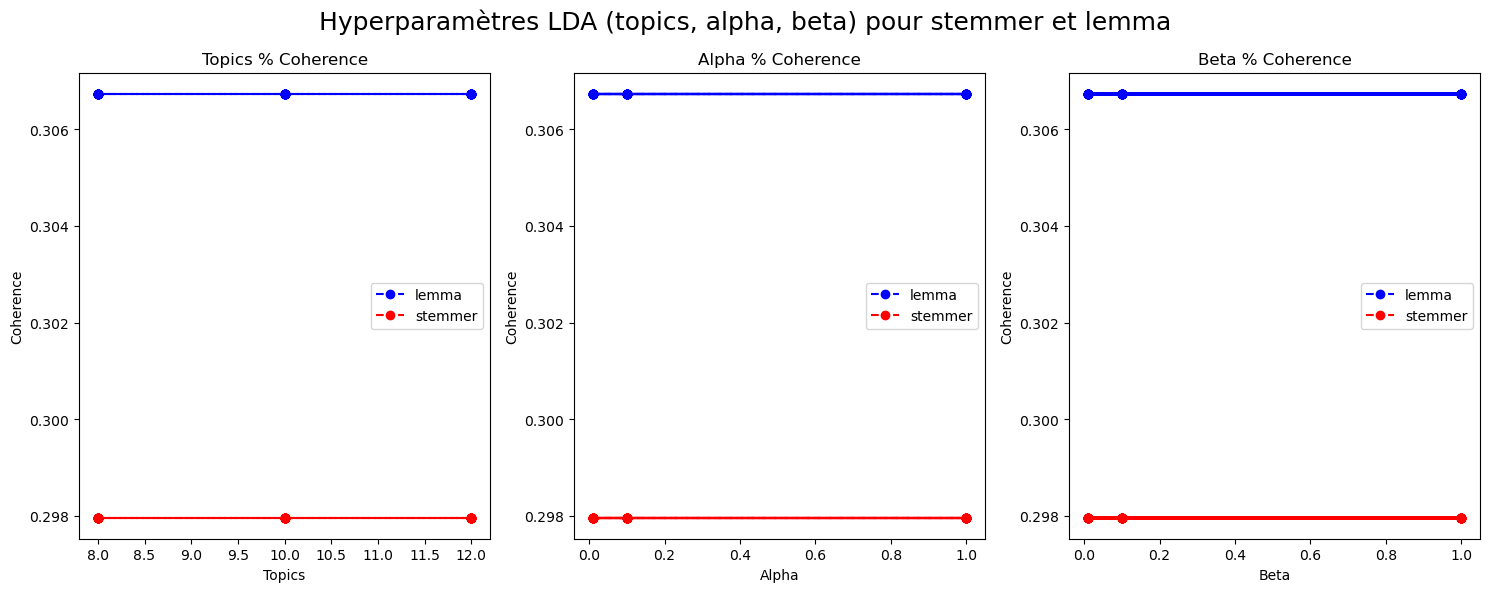

In [49]:
LDA_affichage_hyperparametres()

In [ ]:
#####################################################
# 4) Final Model                                    #
#####################################################

In [53]:
# Maj hyperparamètres : on prend la 1ère valeur de la plage car ils donnent tous le même résultat.
# Remarque : la cohérence est meilleure pour lemma que stemmer.
num_topics = 8    # Number of Topics
alpha      = 0.01 # Alpha parameter
beta       = 0.01 # Beta parameter

In [54]:
lda_model_lemma = gensim.models.LdaMulticore(corpus       = corpus_lemma,
                                             id2word      = id2word_lemma,
                                             num_topics   = num_topics, # hyperparamètre
                                             random_state = 100,
                                             chunksize    = 100,
                                             passes       = 10,
                                             alpha        = alpha,      # hyperparamètre
                                             eta          = beta)       # hyperparamètre

In [55]:
lda_model_stemmer = gensim.models.LdaMulticore(corpus       = corpus_stemmer,
                                               id2word      = id2word_stemmer,
                                               num_topics   = num_topics, # hyperparamètre
                                               random_state = 100,
                                               chunksize    = 100,
                                               passes       = 10,
                                               alpha        = alpha,      # hyperparamètre
                                               eta          = beta)       # hyperparamètre

In [66]:
#####################################################
# 5) Visualize Results                              #
#####################################################
def LDA_Visualize_Results(normalization_type_in, corpus_in, id2word_in, lda_model_in):

    # Visualize the topics
    pyLDAvis.enable_notebook()

    LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+ str(num_topics))

    # this is a bit time consuming - make the if statement True
    # if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = gensimvis.prepare(lda_model_in, corpus_in, id2word_in)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    
    if (normalization_type_in == 'lemma'):
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_lemma_'+ str(num_topics) +'.html')
    elif (normalization_type_in == 'stemmer'):
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_stemmer_'+ str(num_topics) +'.html')
    else:
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

    LDAvis_prepared

In [67]:
LDA_Visualize_Results(normalization_type_in = 'lemma', 
                      corpus_in             = corpus_lemma, 
                      id2word_in            = id2word_lemma, 
                      lda_model_in          = lda_model_lemma)

In [68]:
LDA_Visualize_Results(normalization_type_in = 'stemmer', 
                      corpus_in             = corpus_stemmer, 
                      id2word_in            = id2word_stemmer, 
                      lda_model_in          = lda_model_stemmer)

In [ ]:
# transformation manuelle du fichier html --> jpg

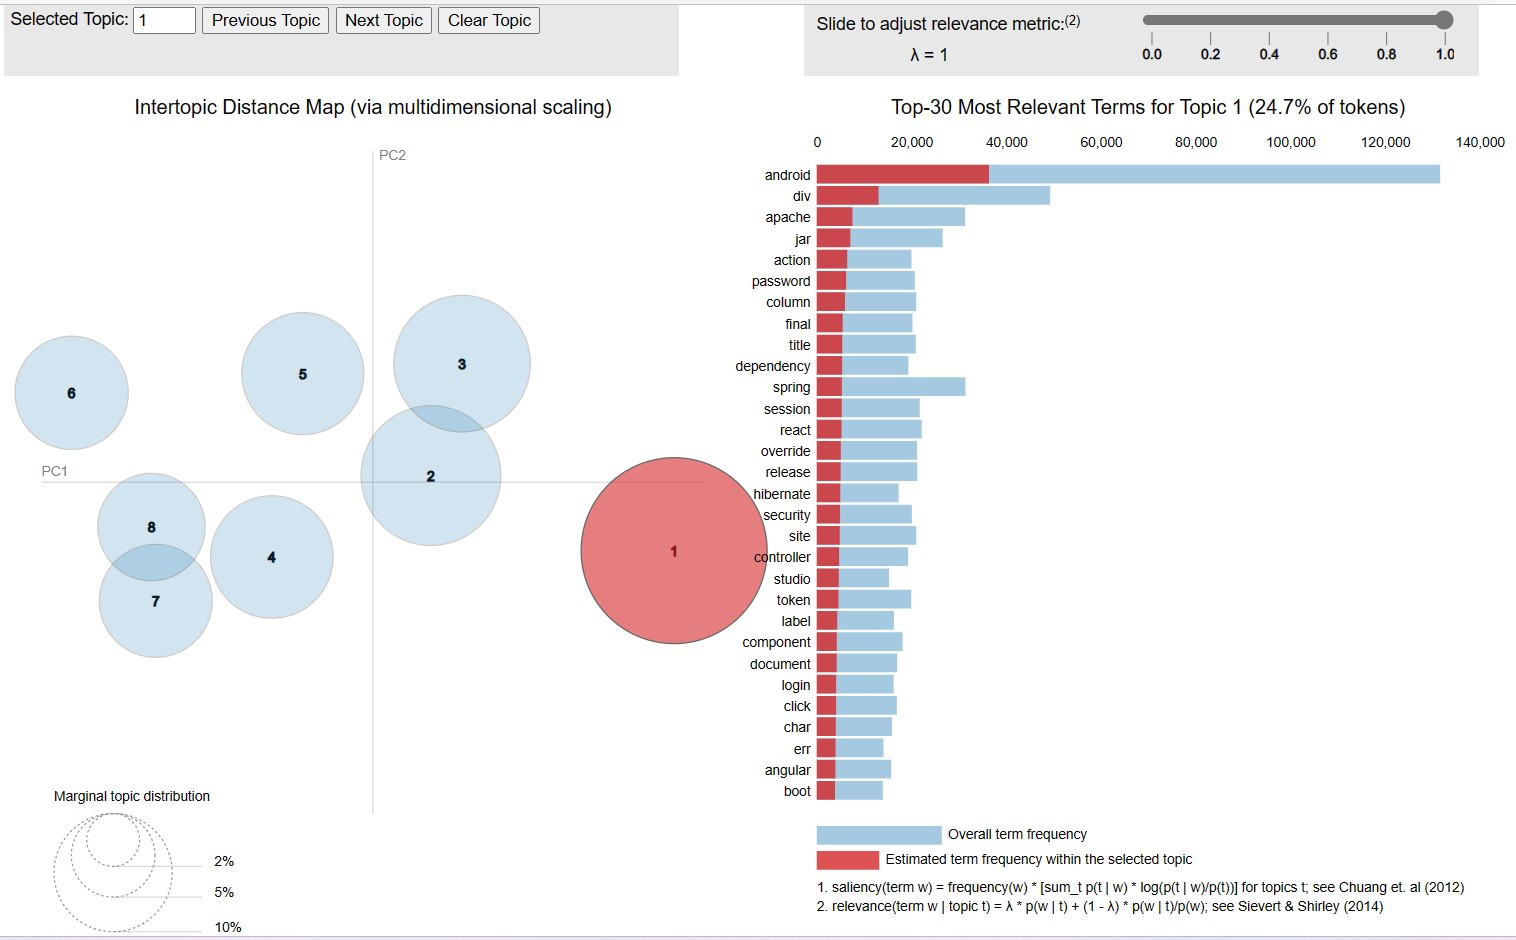

In [57]:
Image.open('./results/ldavis_tuned_lemma_8.jpg')

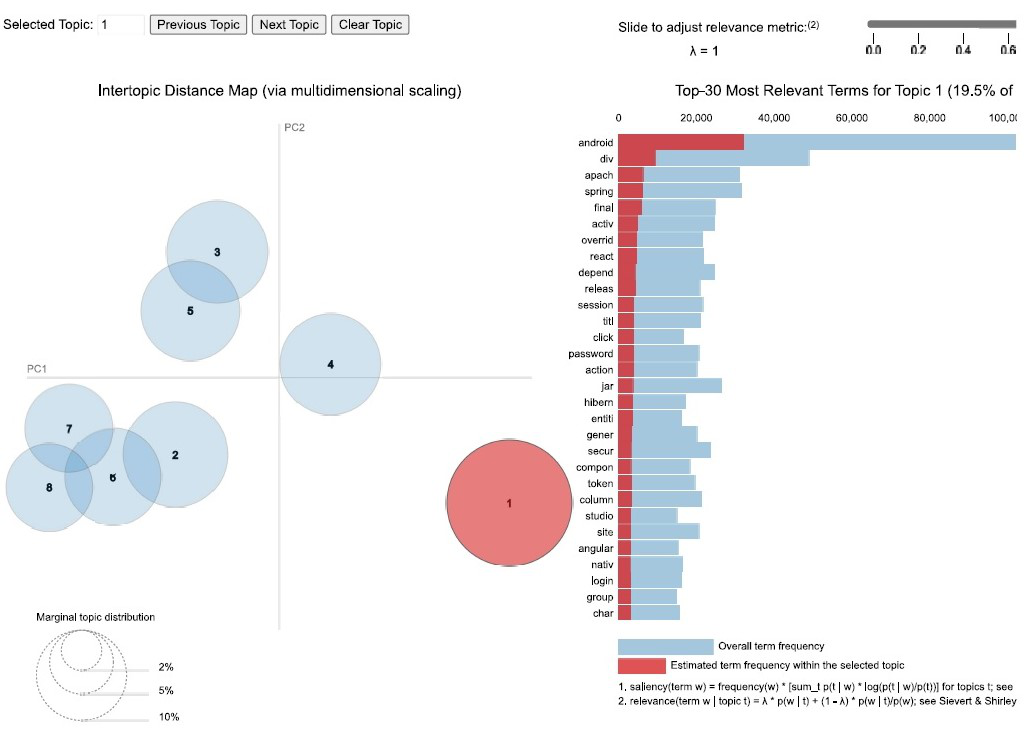

In [56]:
Image.open('./results/ldavis_tuned_stemmer_8.jpg')

# 3. MACHINE LEARNING SUPERVISE - APPROCHE BOW

# 3.1. EXTRACTION DES DONNEES

In [36]:
df.columns

Index(['Id', 'Score', 'AnswerCount', '_Tag_1', '_Tag_2', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_Tokens_text_clean',
       '_Tokens_stemmer_clean', '_Tokens_lemma_clean'],
      dtype='object')

In [37]:
df.head()

Id  Score  AnswerCount _Tag_1       _Tag_2  \
4  4157     27            8     c#         .net   
5  4221     35            6     c#      asp.net   
6  6785    163           12     c#  performance   
7  8896     90           11     c#          c++   
8  8966     23            5     c#         .net   

                                         _Text_clean  \
4  performance class radio time process time proc...   
5  limit limit behind enumerable range take repea...   
6  string format string cat cat append append cat...   
7  get environment get environment setting hostin...   
8  version vista system image sample find referen...   

                                      _Stemmer_clean  \
4  perform class radio time process time process ...   
5  limit limit behind enumer rang take repeat wiz...   
6  string format string cat cat append append cat...   
7  get environ get environ set host solut asp sol...   
8  version vista system imag sampl find refer go ...   

                                        _Lemma_clean  \
4  performance class radio time process time proc...   
5  limit limit behind enumerable range take wizar...   
6  string format string cat cat append append cat...   
7  get environment get environment setting hostin...   
8  version vista system image sample find referen...   

                                  _Tokens_text_clean  \
4  ['performance', 'plan', 'application', 'sectio...   
5  ['limit', 'amount', 'returned', 'like', 'use',...   
6  ['string', 'format', 'efficient', 'suppose', '...   
7  ['get', 'running', 'environment', 'anyone', 'k...   
8  ['version', 'vista', 'scan', 'want', 'implemen...   

                               _Tokens_stemmer_clean  \
4  ['perform', 'class', 'radio', 'time', 'process...   
5  ['limit', 'limit', 'behind', 'enumer', 'rang',...   
6  ['string', 'format', 'string', 'cat', 'cat', '...   
7  ['get', 'environ', 'get', 'environ', 'set', 'h...   
8  ['version', 'vista', 'system', 'imag', 'sampl'...   

                                 _Tokens_lemma_clean  
4  ['performance', 'class', 'radio', 'time', 'pro...  
5  ['limit', 'limit', 'behind', 'enumerable', 'ra...  
6  ['string', 'format', 'string', 'cat', 'cat', '...  
7  ['get', 'environment', 'get', 'environment', '...  
8  ['version', 'vista', 'system', 'image', 'sampl...

# 3.1.1. EXTRACTION DONNEES X

In [ ]:
###############################################
# X : données d'entrée                        #
###############################################

In [ ]:
###############################################
# 1) COLONNES NUMERIQUES                      #
###############################################

In [160]:
# Colonnes :
# --> numériques (à garder)        : 'Id', 'Score', 'AnswerCount', 
# --> y                            : '_Tag_1', '_Tag_2', 
# --> liste de tokens              : '_Text_clean', '_Stemmer_clean', '_Lemma_clean', 
# --> tokens séparés par un espace : '_Tokens_text_clean', '_Tokens_stemmer_clean', '_Tokens_lemma_clean',

# On supprime les y (__Tag_1 et _Tag_2) et les colonnes texte (_xxx_clean) pour ne garder que les colonnes numériques.
df_num = df.drop(['_Tag_1', '_Tag_2',
                  '_Text_clean', '_Stemmer_clean', '_Lemma_clean', 
                  '_Tokens_text_clean', '_Tokens_stemmer_clean', '_Tokens_lemma_clean'], axis = 1)

## Création colonne 'Id' pour pouvoir merger ensuite le dataframe avec un autre
#for index, row in df_num.iterrows():
#    df_num.loc[index, 'Id'] = index
            
            
# Affichage pour vérifier
print('@' * 30, 'df_num', '@' * 30)
print('>' * 7, 'SHAPE :', df_num.shape, '\n')
print('>' * 7, 'COLUMNS :', df_num.columns, '\n')
print('>' * 7, 'HEAD :\n', df_num.head(), '\n\n')

KeyError: "['_Text_clean'] not found in axis"

In [ ]:
###############################################
# 2) COLONNE TEXTE                            #
###############################################
# Travail à part dans les 2 colonnes texte (de manière isolée) :
#   ---> Colonne '_Stemmer_clean' --> corpus_liste_doc_stemmer
#   ---> Colonne '_Lemma_clean' ----> corpus_liste_doc_lemma
#
# corpus = ['This is the first document.',
#           'This document is the second document.',
#           'And this is the third one.',
#           'Is this the first document?']

# 3.1.1.1. APPROCHE BOW / COUNTVECTORIZER

In [ ]:
###########################################################################################################################
# EXTRACTION DE FEATURE A PARTIR DU TEXTE <=> nous créons une matrice de valeurs numériques pour représenter notre texte  #
# APPROCHE DE TYPE BAG-OF-WORDS (BOW) <=> 2 méthodes : CountVectorizer / TfidfVectorizer                                  #
###########################################################################################################################
# https://andhint.github.io/machine-learning/nlp/Feature-Extraction-From-Text/
# https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

In [161]:
###################################################
# Méthode CountVectorizer                         #
###################################################
# CountVectorizer :
#  --> convertit le texte en données numériques.
#  --> adopte une approche bag-of-words (sac de mots) : chaque message est séparé en jetons et le nombre de fois 
#      où chaque jeton apparaît dans un message est compté.

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vect_stemmer = CountVectorizer()
vect_lemma   = CountVectorizer()

In [ ]:
#------------------------------------------------------------------------------------------------#
# Méthode fit :                                                                                  #
#------------------------------------------------------------------------------------------------#
# CountVectorizer() va apprendre quels tokens sont utilisés dans notre corpus_liste_doc_xxx.     #
# corpus list : one string for one document :                                                    #
# corpus = ['This is the first document.',                                                       #
#           'This document is the second document.',                                             #
#           'And this is the third one.',                                                        #
#           'Is this the first document?']                                                       #
#------------------------------------------------------------------------------------------------#

In [162]:
vect_stemmer.fit(corpus_liste_doc_stemmer)

CountVectorizer()

In [163]:
vect_lemma.fit(corpus_liste_doc_lemma)

CountVectorizer()

In [ ]:
#------------------------------------------------------------------------------------------------#
# Vocabulaire :                                                                                  #
# liste de mots uniques, identifés par leur indice dans la matrice                               #
#------------------------------------------------------------------------------------------------#

In [164]:
print(len(vect_stemmer.vocabulary_), 'mots de vocabulaire pour stemmer\n')

# Affichage des 20 premiers mots
res = dict(list(vect_stemmer.vocabulary_.items())[0:20])    
print('20 premiers mots du dictionnaire :', str(res), '\n')

#print('Stemmer vocabulary :', vect_stemmer.vocabulary_)

# Vérification avec le corpus stemmer (corpus_stemmer --> token_stemmer --> count_stemmer)
print('corpus_stemmer =', len(count_stemmer.index.tolist()), 'mots uniques')

1366 mots de vocabulaire pour stemmer

20 premiers mots du dictionnaire : {'perform': 846, 'class': 192, 'radio': 942, 'time': 1240, 'process': 907, 'store': 1164, 'configur': 235, 'load': 685, 'input': 600, 'web': 1342, 'instanc': 606, 'partial': 832, 'trust': 1272, 'solut': 1132, 'add': 14, 'memori': 724, 'disk': 336, 'tell': 1217, 'final': 452, 'save': 1045} 

corpus_stemmer = 1366 mots uniques


In [165]:
print(len(vect_lemma.vocabulary_), 'mots de vocabulaire pour lemma\n')

# Affichage des 20 premiers mots
res = dict(list(vect_lemma.vocabulary_.items())[0:20])    
print('20 premiers mots du dictionnaire :', str(res), '\n')

#print('Lemma vocabulary :', vect_lemma.vocabulary_)

# Vérification avec le corpus stemmer (corpus_lemma --> token_lemma --> count_lemma)
print('corpus_lemma =', len(count_lemma.index.tolist()), 'mots uniques')

1501 mots de vocabulaire pour lemma

20 premiers mots du dictionnaire : {'performance': 932, 'class': 209, 'radio': 1040, 'time': 1370, 'process': 998, 'store': 1288, 'configuration': 258, 'load': 762, 'input': 670, 'web': 1477, 'instance': 678, 'partial': 917, 'trust': 1408, 'solution': 1253, 'add': 14, 'memory': 806, 'disk': 369, 'tell': 1346, 'final': 507, 'save': 1158} 

corpus_lemma = 1501 mots uniques


In [ ]:
#------------------------------------------------------------------------------------------------#
# Méthode get_feature_names :                                                                    #
# liste des features créées pour nos messages (ou qui ont été apprises par CountVectorizer)      #
#------------------------------------------------------------------------------------------------#

In [166]:
print(len(vect_stemmer.get_feature_names()), 'stemmer feature_names\n')
print(vect_stemmer.get_feature_names()[0:30])

1366 stemmer feature_names

['abort', 'absolut', 'abstract', 'access', 'accordion', 'account', 'accuraci', 'acquir', 'across', 'act', 'action', 'activ', 'actor', 'adapt', 'add', 'addit', 'administr', 'ado', 'adob', 'ae', 'affect', 'agent', 'aggreg', 'ai', 'akka', 'alarm', 'album', 'alert', 'algorithm', 'alia']


C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [167]:
print(len(vect_lemma.get_feature_names()), 'lemma feature_names\n')
print(vect_lemma.get_feature_names()[0:30])

1501 lemma feature_names

['abort', 'absolute', 'abstract', 'accessible', 'accordion', 'account', 'accuracy', 'acquire', 'across', 'act', 'action', 'activation', 'actor', 'adapter', 'add', 'addition', 'administrator', 'ado', 'adobe', 'aes', 'affected', 'agent', 'aggregate', 'ai', 'akka', 'alarm', 'album', 'alert', 'algorithm', 'alias']


In [ ]:
#--------------------------------------------------------------------------------------------------#
# DTM (Document Term Matrix) :                                                                     #
# Sparse matrix <=> compressed sparse row format : le corpus se répartit sur différentes features  #
# <=> les lignes seront remplies avec une majorité de zéros.                                       #
#--------------------------------------------------------------------------------------------------#

In [168]:
dtm_lemma = vect_lemma.transform(corpus_liste_doc_lemma)
repr(dtm_lemma)

"<56828x1501 sparse matrix of type '<class 'numpy.int64'>'\n\twith 987833 stored elements in Compressed Sparse Row format>"

In [169]:
dtm_stemmer = vect_stemmer.transform(corpus_liste_doc_stemmer)
repr(dtm_stemmer)

"<56828x1366 sparse matrix of type '<class 'numpy.int64'>'\n\twith 979847 stored elements in Compressed Sparse Row format>"

In [170]:
print(dtm_lemma)

  (0, 14)	1
  (0, 209)	1
  (0, 258)	2
  (0, 369)	2
  (0, 507)	1
  (0, 602)	1
  (0, 670)	1
  (0, 678)	1
  (0, 762)	2
  (0, 806)	1
  (0, 917)	1
  (0, 932)	3
  (0, 998)	2
  (0, 1040)	1
  (0, 1158)	1
  (0, 1253)	1
  (0, 1288)	1
  (0, 1346)	1
  (0, 1355)	1
  (0, 1370)	3
  (0, 1408)	1
  (0, 1451)	1
  (0, 1477)	1
  (1, 121)	1
  (1, 438)	1
  :	:
  (56826, 773)	1
  (56826, 798)	2
  (56826, 865)	1
  (56826, 1019)	1
  (56826, 1021)	1
  (56826, 1106)	4
  (56826, 1117)	3
  (56826, 1125)	1
  (56826, 1128)	2
  (56826, 1172)	1
  (56826, 1175)	1
  (56826, 1185)	2
  (56826, 1239)	1
  (56826, 1287)	6
  (56826, 1288)	3
  (56826, 1294)	1
  (56826, 1302)	5
  (56826, 1317)	1
  (56826, 1467)	1
  (56826, 1497)	1
  (56827, 325)	2
  (56827, 651)	1
  (56827, 818)	1
  (56827, 1045)	1
  (56827, 1370)	2


In [171]:
print(dtm_stemmer)

  (0, 14)	1
  (0, 192)	1
  (0, 235)	2
  (0, 336)	2
  (0, 452)	1
  (0, 540)	1
  (0, 600)	1
  (0, 606)	1
  (0, 685)	2
  (0, 724)	1
  (0, 832)	1
  (0, 846)	3
  (0, 907)	2
  (0, 942)	1
  (0, 1045)	1
  (0, 1132)	1
  (0, 1164)	1
  (0, 1217)	1
  (0, 1225)	1
  (0, 1240)	3
  (0, 1272)	1
  (0, 1316)	1
  (0, 1342)	1
  (1, 109)	1
  (1, 398)	1
  :	:
  (56826, 691)	1
  (56826, 716)	2
  (56826, 779)	1
  (56826, 924)	1
  (56826, 926)	1
  (56826, 998)	4
  (56826, 1008)	3
  (56826, 1013)	1
  (56826, 1016)	2
  (56826, 1058)	1
  (56826, 1061)	1
  (56826, 1068)	2
  (56826, 1118)	1
  (56826, 1163)	6
  (56826, 1164)	3
  (56826, 1169)	1
  (56826, 1177)	5
  (56826, 1191)	1
  (56826, 1332)	1
  (56826, 1362)	1
  (56827, 296)	2
  (56827, 586)	1
  (56827, 735)	1
  (56827, 947)	1
  (56827, 1240)	2


In [ ]:
#------------------------------------------------------------------------------------------------------#
# Conversion spare matrix --> dense matrix (pour gagner de la place)                                   #
#------------------------------------------------------------------------------------------------------#

In [173]:
df_lemma = pd.DataFrame(dtm_lemma.toarray(), columns = vect_lemma.get_feature_names())
print(df_lemma)

       abort  absolute  abstract  accessible  accordion  account  accuracy  \
0          0         0         0           0          0        0         0   
1          0         0         0           0          0        0         0   
2          0         0         0           0          0        0         0   
3          0         0         0           0          0        0         0   
4          0         0         0           0          0        0         0   
...      ...       ...       ...         ...        ...      ...       ...   
56823      0         0         0           0          0        0         0   
56824      0         0         0           0          0        0         0   
56825      0         0         0           0          0        0         0   
56826      0         0         0           0          0        0         0   
56827      0         0         0           0          0        0         0   

       acquire  across  act  ...  writer  yarn  yellow  yield  

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [174]:
df_stemmer = pd.DataFrame(dtm_stemmer.toarray(), columns = vect_stemmer.get_feature_names())
print(df_stemmer)

       abort  absolut  abstract  access  accordion  account  accuraci  acquir  \
0          0        0         0       0          0        0         0       0   
1          0        0         0       0          0        0         0       0   
2          0        0         0       0          0        0         0       0   
3          0        0         0       0          0        0         0       0   
4          0        0         0       0          0        0         0       0   
...      ...      ...       ...     ...        ...      ...       ...     ...   
56823      0        0         0       0          0        0         0       0   
56824      0        0         0       0          0        0         0       0   
56825      0        0         0       0          0        0         0       0   
56826      0        0         0       0          0        0         0       0   
56827      0        0         0       0          0        0         0       0   

       across  act  ...  wr

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [175]:
df_lemma.columns

Index(['abort', 'absolute', 'abstract', 'accessible', 'accordion', 'account',
       'accuracy', 'acquire', 'across', 'act',
       ...
       'writer', 'yarn', 'yellow', 'yield', 'za', 'zend', 'zero', 'zip',
       'zone', 'zoom'],
      dtype='object', length=1501)

In [176]:
df_stemmer.columns

Index(['abort', 'absolut', 'abstract', 'access', 'accordion', 'account',
       'accuraci', 'acquir', 'across', 'act',
       ...
       'writer', 'yarn', 'yellow', 'yield', 'za', 'zend', 'zero', 'zip',
       'zone', 'zoom'],
      dtype='object', length=1366)

In [177]:
print('df_lemma shape\t\t=', df_lemma.shape)
print('df_stemmer shape\t=', df_stemmer.shape)

df_lemma shape		= (56828, 1501)
df_stemmer shape	= (56828, 1366)


In [ ]:
###############################################
# 3) MERGE DES 2 DATAFRAMES                   #
###############################################

In [178]:
print('df_num shape\t\t=', df_num.shape)
print('df_lemma shape\t\t=', df_lemma.shape)
print('df_stemmer shape\t=', df_stemmer.shape)

df_num shape		= (56828, 3)
df_lemma shape		= (56828, 1501)
df_stemmer shape	= (56828, 1366)


In [60]:
#############################################
#        X_lemma = df_num + df_lemma        #
#############################################
# how = inner (valeur par défaut) <=> clés présentes dans les 2 dataframes(cela évite les cellules NaN).
X_lemma = pd.concat([df_num, df_lemma], axis = 1)
#X_lemma = pd.merge(df_num, df_lemma, on = 'Id')

In [61]:
#############################################
#     X_stemmer = df_num + df_stemmer       #
#############################################
X_stemmer = pd.concat([df_num, df_stemmer], axis = 1)

In [62]:
print('X_lemma shape\t=', X_lemma.shape)
print('X_stemmer shape\t=', X_stemmer.shape)

X_lemma shape	= (94744, 1504)
X_stemmer shape	= (94744, 1369)


# 3.1.2. EXTRACTION DONNEES Y

In [ ]:
###############################################
# y : données de sortie (résultat)            #
###############################################

In [179]:
# Copie des 2 sorties y (_Tag_1 et _Tag_2) dans un dataframe.
df_y = df[['_Tag_1', '_Tag_2']].copy()
df_y.shape

(56828, 2)

In [180]:
# Vérification n°1
for index, row in df.iterrows():
    if (row['_Tag_1'] != df_y.loc[index, '_Tag_1']):
        print('index =', index, ': _Tag_1 différent : df =', row['_Tag_1'], ', df_y =', df_y.loc[index, '_Tag_1'])
    if (row['_Tag_2'] != df_y.loc[index, '_Tag_2']):
        print('index =', index, ': _Tag_2 différent : df =', row['_Tag_2'], ', df_y =', df_y.loc[index, '_Tag_2'])

In [181]:
# Vérification n°2
print('@' * 16, 'df - head :', '@' * 16, '\n', df[['_Tag_1', '_Tag_2']].head(), '\n\n')
print('@' * 15, 'df_y - head :', '@' * 15, '\n', df_y.head(), '\n\n')

print('@' * 16, 'df - tail :', '@' * 16, '\n', df[['_Tag_1', '_Tag_2']].tail(), '\n\n')
print('@' * 15, 'df_y - tail :', '@' * 15, '\n', df_y.tail())

@@@@@@@@@@@@@@@@ df - head : @@@@@@@@@@@@@@@@ 
   _Tag_1       _Tag_2
4     c#         .net
5     c#      asp.net
6     c#  performance
7     c#          c++
8     c#         .net 


@@@@@@@@@@@@@@@ df_y - head : @@@@@@@@@@@@@@@ 
   _Tag_1       _Tag_2
4     c#         .net
5     c#      asp.net
6     c#  performance
7     c#          c++
8     c#         .net 


@@@@@@@@@@@@@@@@ df - tail : @@@@@@@@@@@@@@@@ 
             _Tag_1       _Tag_2
185157       swift        xcode
185162  javascript  performance
185166         c++            c
185169         ios        swift
185173      python  performance 


@@@@@@@@@@@@@@@ df_y - tail : @@@@@@@@@@@@@@@ 
             _Tag_1       _Tag_2
185157       swift        xcode
185162  javascript  performance
185166         c++            c
185169         ios        swift
185173      python  performance


In [182]:
# Conversion dataframe --> liste
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ Y : df_y --> list_y                                    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# https://stacklima.com/comment-convertir-pandas-dataframe-en-une-liste/
list_y = df_y.values.tolist()

# Vérification
print('list_y :')
print('\t- nb éléments\t\t=', len(list_y))
print('\t- 5 premiers éléments\t=', list_y[0:5])

list_y :
	- nb éléments		= 56828
	- 5 premiers éléments	= [['c#', '.net'], ['c#', 'asp.net'], ['c#', 'performance'], ['c#', 'c++'], ['c#', '.net']]


In [184]:
# Suppression valeurs vides (qui correspondent à _Tag_2 non renseignés).
# https://stacklima.com/python-supprimer-les-chaines-vides-de-la-liste-des-chaines/
for i in range(len(list_y)):  
    ligne = list_y[i]
    print('avant :', i, list_y[i])
    
    if ('' in ligne):
        list_y[i].remove('')
    print('après :', i, list_y[i], '\n')

avant : 0 ['c#', '.net']
après : 0 ['c#', '.net'] 

avant : 1 ['c#', 'asp.net']
après : 1 ['c#', 'asp.net'] 

avant : 2 ['c#', 'performance']
après : 2 ['c#', 'performance'] 

avant : 3 ['c#', 'c++']
après : 3 ['c#', 'c++'] 

avant : 4 ['c#', '.net']
après : 4 ['c#', '.net'] 

avant : 5 ['java', 'json']
après : 5 ['java', 'json'] 

avant : 6 ['c#', '.net']
après : 6 ['c#', '.net'] 

avant : 7 ['asp.net', 'performance']
après : 7 ['asp.net', 'performance'] 

avant : 8 ['c++', 'linux']
après : 8 ['c++', 'linux'] 

avant : 9 ['.net', 'performance']
après : 9 ['.net', 'performance'] 

avant : 10 ['c#', '.net']
après : 10 ['c#', '.net'] 

avant : 11 ['c#', '.net']
après : 11 ['c#', '.net'] 

avant : 12 ['c#', '.net']
après : 12 ['c#', '.net'] 

avant : 13 ['c#', 'asp.net']
après : 13 ['c#', 'asp.net'] 

avant : 14 ['c#', '.net']
après : 14 ['c#', '.net'] 

avant : 15 ['c#', 'asp.net']
après : 15 ['c#', 'asp.net'] 

avant : 16 ['html', 'css']
après : 16 ['html', 'css'] 

avant : 17 ['java', 

avant : 2457 ['java', 'c#']
après : 2457 ['java', 'c#'] 

avant : 2458 ['.net', 'asp.net']
après : 2458 ['.net', 'asp.net'] 

avant : 2459 ['java', 'performance']
après : 2459 ['java', 'performance'] 

avant : 2460 ['jquery', 'css']
après : 2460 ['jquery', 'css'] 

avant : 2461 ['javascript', 'jquery']
après : 2461 ['javascript', 'jquery'] 

avant : 2462 ['c#', '.net']
après : 2462 ['c#', '.net'] 

avant : 2463 ['c#', '.net']
après : 2463 ['c#', '.net'] 

avant : 2464 ['c#', '.net']
après : 2464 ['c#', '.net'] 

avant : 2465 ['c#', 'c++']
après : 2465 ['c#', 'c++'] 

avant : 2466 ['ios', 'objective-c']
après : 2466 ['ios', 'objective-c'] 

avant : 2467 ['c++', 'c']
après : 2467 ['c++', 'c'] 

avant : 2468 ['java', 'linux']
après : 2468 ['java', 'linux'] 

avant : 2469 ['python', 'linux']
après : 2469 ['python', 'linux'] 

avant : 2470 ['c#', '.net']
après : 2470 ['c#', '.net'] 

avant : 2471 ['java', '.net']
après : 2471 ['java', '.net'] 

avant : 2472 ['c#', 'c++']
après : 2472 ['c#',

après : 8466 ['php', 'jquery'] 

avant : 8467 ['c#', '.net']
après : 8467 ['c#', '.net'] 

avant : 8468 ['javascript', 'jquery']
après : 8468 ['javascript', 'jquery'] 

avant : 8469 ['ios', 'objective-c']
après : 8469 ['ios', 'objective-c'] 

avant : 8470 ['ios', 'iphone']
après : 8470 ['ios', 'iphone'] 

avant : 8471 ['c#', '.net']
après : 8471 ['c#', '.net'] 

avant : 8472 ['c#', '.net']
après : 8472 ['c#', '.net'] 

avant : 8473 ['objective-c', 'iphone']
après : 8473 ['objective-c', 'iphone'] 

avant : 8474 ['ruby-on-rails', 'json']
après : 8474 ['ruby-on-rails', 'json'] 

avant : 8475 ['java', 'android']
après : 8475 ['java', 'android'] 

avant : 8476 ['java', 'javascript']
après : 8476 ['java', 'javascript'] 

avant : 8477 ['ios', 'iphone']
après : 8477 ['ios', 'iphone'] 

avant : 8478 ['javascript', 'html']
après : 8478 ['javascript', 'html'] 

avant : 8479 ['javascript', 'html']
après : 8479 ['javascript', 'html'] 

avant : 8480 ['html', 'php']
après : 8480 ['html', 'php'] 

ava

après : 16132 ['javascript', 'html'] 

avant : 16133 ['javascript', 'html']
après : 16133 ['javascript', 'html'] 

avant : 16134 ['c#', '.net']
après : 16134 ['c#', '.net'] 

avant : 16135 ['objective-c', 'iphone']
après : 16135 ['objective-c', 'iphone'] 

avant : 16136 ['c#', 'python']
après : 16136 ['c#', 'python'] 

avant : 16137 ['c#', '.net']
après : 16137 ['c#', '.net'] 

avant : 16138 ['java', 'c#']
après : 16138 ['java', 'c#'] 

avant : 16139 ['c++', 'c']
après : 16139 ['c++', 'c'] 

avant : 16140 ['javascript', 'ios']
après : 16140 ['javascript', 'ios'] 

avant : 16141 ['c', 'performance']
après : 16141 ['c', 'performance'] 

avant : 16142 ['c#', 'asp.net']
après : 16142 ['c#', 'asp.net'] 

avant : 16143 ['javascript', 'html']
après : 16143 ['javascript', 'html'] 

avant : 16144 ['c#', '.net']
après : 16144 ['c#', '.net'] 

avant : 16145 ['c#', '.net']
après : 16145 ['c#', '.net'] 

avant : 16146 ['objective-c', 'xcode']
après : 16146 ['objective-c', 'xcode'] 

avant : 16147 [

avant : 25240 ['javascript', 'html']
après : 25240 ['javascript', 'html'] 

avant : 25241 ['python', 'c++']
après : 25241 ['python', 'c++'] 

avant : 25242 ['c', 'linux']
après : 25242 ['c', 'linux'] 

avant : 25243 ['c#', 'asp.net']
après : 25243 ['c#', 'asp.net'] 

avant : 25244 ['java', 'sql']
après : 25244 ['java', 'sql'] 

avant : 25245 ['php', 'linux']
après : 25245 ['php', 'linux'] 

avant : 25246 ['javascript', 'html']
après : 25246 ['javascript', 'html'] 

avant : 25247 ['c#', '.net']
après : 25247 ['c#', '.net'] 

avant : 25248 ['javascript', 'android']
après : 25248 ['javascript', 'android'] 

avant : 25249 ['objective-c', 'iphone']
après : 25249 ['objective-c', 'iphone'] 

avant : 25250 ['java', 'jquery']
après : 25250 ['java', 'jquery'] 

avant : 25251 ['objective-c', 'xcode']
après : 25251 ['objective-c', 'xcode'] 

avant : 25252 ['php', 'css']
après : 25252 ['php', 'css'] 

avant : 25253 ['javascript', 'ios']
après : 25253 ['javascript', 'ios'] 

avant : 25254 ['c#', 'as

avant : 34329 ['javascript', 'html']
après : 34329 ['javascript', 'html'] 

avant : 34330 ['ios', 'objective-c']
après : 34330 ['ios', 'objective-c'] 

avant : 34331 ['java', 'android']
après : 34331 ['java', 'android'] 

avant : 34332 ['javascript', 'ios']
après : 34332 ['javascript', 'ios'] 

avant : 34333 ['java', 'spring']
après : 34333 ['java', 'spring'] 

avant : 34334 ['ios', 'objective-c']
après : 34334 ['ios', 'objective-c'] 

avant : 34335 ['c#', '.net']
après : 34335 ['c#', '.net'] 

avant : 34336 ['java', 'spring']
après : 34336 ['java', 'spring'] 

avant : 34337 ['ios', 'swift']
après : 34337 ['ios', 'swift'] 

avant : 34338 ['ios', 'objective-c']
après : 34338 ['ios', 'objective-c'] 

avant : 34339 ['c#', 'performance']
après : 34339 ['c#', 'performance'] 

avant : 34340 ['c++', 'c']
après : 34340 ['c++', 'c'] 

avant : 34341 ['java', 'android']
après : 34341 ['java', 'android'] 

avant : 34342 ['java', 'android']
après : 34342 ['java', 'android'] 

avant : 34343 ['javasc

avant : 43267 ['java', 'spring']
après : 43267 ['java', 'spring'] 

avant : 43268 ['python', 'performance']
après : 43268 ['python', 'performance'] 

avant : 43269 ['java', 'spring']
après : 43269 ['java', 'spring'] 

avant : 43270 ['ios', 'swift']
après : 43270 ['ios', 'swift'] 

avant : 43271 ['android', 'json']
après : 43271 ['android', 'json'] 

avant : 43272 ['ios', 'swift']
après : 43272 ['ios', 'swift'] 

avant : 43273 ['java', 'android']
après : 43273 ['java', 'android'] 

avant : 43274 ['javascript', 'html']
après : 43274 ['javascript', 'html'] 

avant : 43275 ['ios', 'swift']
après : 43275 ['ios', 'swift'] 

avant : 43276 ['c#', '.net']
après : 43276 ['c#', '.net'] 

avant : 43277 ['ios', 'swift']
après : 43277 ['ios', 'swift'] 

avant : 43278 ['java', 'spring']
après : 43278 ['java', 'spring'] 

avant : 43279 ['c#', '.net']
après : 43279 ['c#', '.net'] 

avant : 43280 ['javascript', 'html']
après : 43280 ['javascript', 'html'] 

avant : 43281 ['c#', '.net']
après : 43281 ['c

avant : 52054 ['javascript', 'html']
après : 52054 ['javascript', 'html'] 

avant : 52055 ['c#', 'asp.net']
après : 52055 ['c#', 'asp.net'] 

avant : 52056 ['java', 'spring']
après : 52056 ['java', 'spring'] 

avant : 52057 ['javascript', 'python']
après : 52057 ['javascript', 'python'] 

avant : 52058 ['c', 'linux']
après : 52058 ['c', 'linux'] 

avant : 52059 ['node.js', 'json']
après : 52059 ['node.js', 'json'] 

avant : 52060 ['javascript', 'node.js']
après : 52060 ['javascript', 'node.js'] 

avant : 52061 ['java', 'spring']
après : 52061 ['java', 'spring'] 

avant : 52062 ['c#', 'asp.net']
après : 52062 ['c#', 'asp.net'] 

avant : 52063 ['ios', 'swift']
après : 52063 ['ios', 'swift'] 

avant : 52064 ['java', 'android']
après : 52064 ['java', 'android'] 

avant : 52065 ['ios', 'swift']
après : 52065 ['ios', 'swift'] 

avant : 52066 ['javascript', 'html']
après : 52066 ['javascript', 'html'] 

avant : 52067 ['javascript', 'node.js']
après : 52067 ['javascript', 'node.js'] 

avant : 

In [68]:
# Vérification après remplacement de '/' par ''
print('list_y (après remplacement de \'/\' par \'\') :')
print('\t- nb éléments\t\t=', len(list_y))
print('\t- 5 premiers éléments\t=', list_y[0:5])

list_y (après remplacement de '/' par '') :
	- nb éléments		= 56828
	- 5 premiers éléments	= [['c#', '.net'], ['c#', 'asp.net'], ['c#', 'performance'], ['c#', 'c++'], ['c#', '.net']]


In [69]:
########################################################################################################
# Nous sommes dans un cas de Multi-label text classification, car la sortie est sur _Tag_1 et _Tag_2.  #
# => Transform between iterable of iterables and a multilabel format.                                  #
########################################################################################################

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
# https://scikit-learn.org/stable/modules/preprocessing_targets.html
# https://medium.com/analytics-vidhya/multi-label-text-classification-for-beginners-in-less-than-five-5-minutes-19502a96cf39

mlb = MultiLabelBinarizer()

#----------------------------------------------------------------------------------------------
# fit_transform(y) : Fit the label sets binarizer and transform the given label sets.
# Parameters:
#   - y : iterable of iterables.
#     A set of labels (any orderable and hashable object) for each sample. If the classes parameter is set, 
#     y will not be iterated.

# Returns:
#    - y_indicator{ndarray, sparse matrix} of shape (n_samples, n_classes).
#      A matrix such that y_indicator[i, j] = 1 iff classes_[j] is in y[i], and 0 otherwise. 
#      Sparse matrix will be of CSR format.
#----------------------------------------------------------------------------------------------
mlb_indicator = mlb.fit_transform(list_y)

print(type(mlb_indicator))
mlb_indicator

<class 'numpy.ndarray'>


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [70]:
print('classes_ :')
print('\t- nb éléments\t=', len(mlb.classes_))
print('\t- liste\t\t=\n', mlb.classes_)

classes_ :
	- nb éléments	= 25
	- liste		=
 ['.net' 'android' 'asp.net' 'c' 'c#' 'c++' 'css' 'html' 'ios' 'iphone'
 'java' 'javascript' 'jquery' 'json' 'linux' 'node.js' 'objective-c'
 'performance' 'php' 'python' 'ruby-on-rails' 'spring' 'sql' 'swift'
 'xcode']


In [71]:
#y = np.array(mlb)
y = mlb_indicator

In [72]:
y.shape

(56828, 25)

In [73]:
print(y)

[[1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


# 3.2. REDUCTION DE DIMENSION (ACP)

In [ ]:
# https://ichi.pro/fr/analyse-en-composantes-principales-acp-avec-scikit-learn-33554981925296
# https://stacklima.com/analyse-des-composants-principaux-avec-python/

In [ ]:
########################################################################
# Standardisation des données (uniquement si problème de performance)  #
########################################################################
# https://ichi.pro/fr/pca-utilisant-python-scikit-learn-253248327425632
# https://www.geeksforgeeks.org/how-to-standardize-data-in-a-pandas-dataframe/
# https://www.kaggle.com/code/lilyelizabethjohn/standardization-using-standardscaler
# https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# https://stacklima.com/comment-mettre-a-l-echelle-les-colonnes-pandas-dataframe/

In [67]:
# Define standard scaler
scaler_lemma   = StandardScaler()
scaler_stemmer = StandardScaler()

In [68]:
# Transform data
X_norm_lemma = scaler_lemma.fit_transform(X_lemma)

# Maj type : numpy.ndarray --> panda dataframe
X_norm_lemma = pd.DataFrame(X_norm_lemma, columns = X_lemma.columns)

print ('X_norm_lemma =', X_norm_lemma.shape)

X_norm_lemma = (15000, 2578)


In [69]:
# Transform data
X_norm_stemmer = scaler_stemmer.fit_transform(X_stemmer)

# Maj type : numpy.ndarray --> panda dataframe
X_norm_stemmer = pd.DataFrame(X_norm_stemmer, columns = X_stemmer.columns)

print ('X_norm_stemmer =', X_norm_stemmer.shape)

X_norm_stemmer = (15000, 2194)


In [70]:
# Vérification que la moyenne = 0 et l'écart type = 1
idx = ['mean', 'std']

In [71]:
pd.DataFrame(X_norm_lemma).describe().round(2).loc[idx, :].transpose()  # transpose met les attributs en ligne pour + de lisibilité

mean  std
Id            0.0  1.0
Score        -0.0  1.0
AnswerCount  -0.0  1.0
abort        -0.0  1.0
absolute      0.0  1.0
...           ...  ...
zend          0.0  1.0
zero          0.0  1.0
zip          -0.0  1.0
zone         -0.0  1.0
zoom         -0.0  1.0

[2578 rows x 2 columns]

In [72]:
pd.DataFrame(X_norm_stemmer).describe().round(2).loc[idx, :].transpose()  # transpose met les attributs en ligne pour + de lisibilité

mean  std
Id            0.0  1.0
Score        -0.0  1.0
AnswerCount  -0.0  1.0
abort        -0.0  1.0
absolut       0.0  1.0
...           ...  ...
zend          0.0  1.0
zero          0.0  1.0
zip          -0.0  1.0
zone         -0.0  1.0
zoom         -0.0  1.0

[2194 rows x 2 columns]

In [306]:
###########################################################################################
# ACP sur notre ensemble de données pour voir comment il capture la variance des données. #
###########################################################################################
def PCA_all(data_in):
    
    # Nombre de colonnes
    nb_colonnes = len(data_in.columns)
    print('nb_colonnes = ', nb_colonnes)
    
    
    # PCA sur l'ensemble des données
    pca_all = PCA(n_components = nb_colonnes)
    pca_all.fit(data_in)
    
    
    # Explained variance
    pca_all.explained_variance_ratio_    
    
    # Variance captée pour chaque composante
    scree = (pca_all.explained_variance_ratio_ * 100).round(2)
    print('scree =', scree) 
    
    # Somme cumulée
    scree_cum = scree.cumsum().round()
    print('scree_cum =', scree_cum, '\n')

    print('Variance explained by the First principal component\t=', np.cumsum(pca_all.explained_variance_ratio_ * 100)[0])
    print('Variance explained by the 2 principal components\t=', np.cumsum(pca_all.explained_variance_ratio_ * 100)[1])
    print('Variance explained by the 3 principal components\t=', np.cumsum(pca_all.explained_variance_ratio_ * 100)[2])
    print('Variance explained by the 10 principal components\t=', np.cumsum(pca_all.explained_variance_ratio_ * 100)[9])
    print('Variance explained by the 25 principal components\t=', np.cumsum(pca_all.explained_variance_ratio_ * 100)[24])    
    print('Variance explained by the 50 principal components\t=', np.cumsum(pca_all.explained_variance_ratio_ * 100)[49])
    if (nb_colonnes >= 99):
        print('Variance explained by the 100 principal components\t=', 
              np.cumsum(pca_all.explained_variance_ratio_ * 100)[99])
    if (nb_colonnes >= 499):
        print('Variance explained by the 500 principal components\t=', 
              np.cumsum(pca_all.explained_variance_ratio_ * 100)[499])
    if (nb_colonnes >= 749):
        print('Variance explained by the 750 principal components\t=', 
              np.cumsum(pca_all.explained_variance_ratio_ * 100)[749])        
    if (nb_colonnes >= 999):
        print('Variance explained by the 1000 principal components\t=', 
              np.cumsum(pca_all.explained_variance_ratio_ * 100)[999]) 
    if (nb_colonnes >= 1199):
        print('Variance explained by the 1200 principal components\t=', 
              np.cumsum(pca_all.explained_variance_ratio_ * 100)[1199]) 
    if (nb_colonnes >= 1499):
        print('Variance explained by the 1500 principal components\t=', 
              np.cumsum(pca_all.explained_variance_ratio_ * 100)[1499])   
    if (nb_colonnes >= 1999):
        print('Variance explained by the 2000 principal components\t=', 
              np.cumsum(pca_all.explained_variance_ratio_ * 100)[1999])
    if (nb_colonnes >= 2499):
        print('Variance explained by the 2500 principal components\t=', 
              np.cumsum(pca_all.explained_variance_ratio_ * 100)[2499])        
    
    # Variable avec la liste de nos composantes :
    x_list = range(1, nb_colonnes + 1)
    list(x_list)
    
    # Graphique éboulis des valeurs graphiques (scree plot)
    # Remarque : on a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum, c = 'red', marker = 'o')
    plt.xlabel('Rang de l\'axe d\'inertie')
    plt.ylabel('Pourcentage d\'inertie')
    plt.title('Eboulis des valeurs propres')
    plt.show(block = False)

In [307]:
# Maj liste colonnes des principales composantes ('PC1', ..., 'PC1000')
def nom_colonne_PCA(nb_composant_in):
    columns = []
    for i in range(nb_composant_in):
        columns.append('PC' + str(i+1))
    print('10 premières colonnes :', columns[0:10])
    print('10 dernières colonnes :', columns[nb_composant_in-10:nb_composant_in])
    return columns

In [308]:
def PCA_reduit(data_in, n_components_in):
    
    # Appliquons PCA sur un nombre réduit de composants
    pca_reduit = PCA(n_components = n_components_in)
    pca_reduit.fit(data_in)
    data_pca_reduit = pca_reduit.transform(data_in)
    
    return data_pca_reduit

In [ ]:
#############################################
# PCA pour X_lemma                          #
#############################################

nb_colonnes =  2578
scree = [0.42 0.38 0.3  ... 0.   0.   0.  ]
scree_cum = [  0.   1.   1. ... 100. 100. 100.] 

Variance explained by the First principal component	= 0.42235088197683435
Variance explained by the 2 principal components	= 0.7973603762093615
Variance explained by the 3 principal components	= 1.0994283900849895
Variance explained by the 10 principal components	= 2.5460235126306006
Variance explained by the 25 principal components	= 4.831844788198439
Variance explained by the 50 principal components	= 7.952393142583177
Variance explained by the 100 principal components	= 13.117993779634974
Variance explained by the 500 principal components	= 41.31955100177195
Variance explained by the 750 principal components	= 54.1315636035746
Variance explained by the 1000 principal components	= 64.9082428790388
Variance explained by the 1200 principal components	= 72.39011763497447
Variance explained by the 1500 principal components	= 81.8360746817938
Variance explained by the 2000 pri

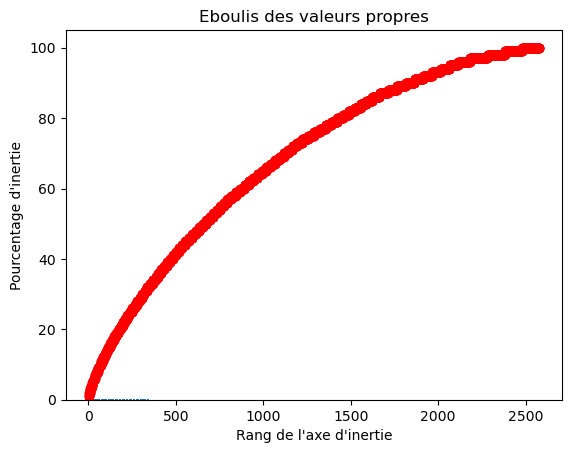

In [309]:
# PCA sur toutes les données
PCA_all(data_in = X_norm_lemma)

# 72% de la variance est comprise dans les 1.200 premières composantes sur 2217.
# 81% de la variance est comprise dans les 1.500 premières composantes sur 2217.
# 93% de la variance est comprise dans les 2.000 premières composantes sur 2217.

In [ ]:
#-----------------------------------------#
# Calculs pour > 70% de variance :        #
# 72% avec 1.200 composants principaux    #
#-----------------------------------------#

In [313]:
X_lemma_pca_1200 = PCA_reduit(data_in         = X_norm_lemma,
                              n_components_in = 1200)

In [314]:
X_lemma_new_1200 = pd.DataFrame(X_lemma_pca_1200, 
                                columns = nom_colonne_PCA(nb_composant_in = 1200))

X_lemma_new_1200.shape

10 premières colonnes : ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
10 dernières colonnes : ['PC1191', 'PC1192', 'PC1193', 'PC1194', 'PC1195', 'PC1196', 'PC1197', 'PC1198', 'PC1199', 'PC1200']


(15000, 1200)

In [ ]:
#############################################
# PCA pour X_stemmer                        #
#############################################

nb_colonnes =  2194
scree = [0.47 0.43 0.34 ... 0.   0.   0.  ]
scree_cum = [  0.   1.   1. ... 100. 100. 100.] 

Variance explained by the First principal component	= 0.4728980346937392
Variance explained by the 2 principal components	= 0.9027969440740181
Variance explained by the 3 principal components	= 1.2427666922322491
Variance explained by the 10 principal components	= 2.7989064379273896
Variance explained by the 25 principal components	= 5.314490335267067
Variance explained by the 50 principal components	= 8.741298454921232
Variance explained by the 100 principal components	= 14.352093909282804
Variance explained by the 500 principal components	= 44.908097062454196
Variance explained by the 750 principal components	= 58.72379132094221
Variance explained by the 1000 principal components	= 70.291738451577
Variance explained by the 1200 principal components	= 78.15904171642639
Variance explained by the 1500 principal components	= 87.72923197553031
Variance explained by the 2000 pr

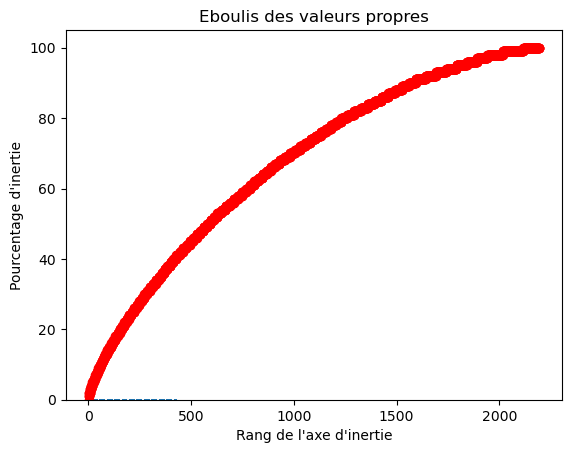

In [312]:
# PCA sur toutes les données
PCA_all(data_in = X_norm_stemmer)

# 70% de la variance est comprise dans les 1.000 premières composantes sur 2194.
# 78% de la variance est comprise dans les 1.200 premières composantes sur 2194.
# 87% de la variance est comprise dans les 1.500 premières composantes sur 2194.
# 98% de la variance est comprise dans les 2.000 premières composantes sur 2194.

In [ ]:
#-----------------------------------------#
# Calculs pour > 70% de variance :        #
# 70% avec 1.000 composants principaux    #
#-----------------------------------------#

In [145]:
X_stemmer_pca_1000 = PCA_reduit(data_in         = X_norm_stemmer,
                                n_components_in = 1000)

In [146]:
X_stemmer_new_1000 = pd.DataFrame(X_stemmer_pca_1000, 
                                  columns = nom_colonne_PCA(nb_composant_in = 1000))

X_stemmer_new_1000.shape

10 premières colonnes : ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
10 dernières colonnes : ['PC991', 'PC992', 'PC993', 'PC994', 'PC995', 'PC996', 'PC997', 'PC998', 'PC999', 'PC1000']


(15000, 1000)

In [ ]:
#-----------------------------------------#
# Calculs pour > 95% de variance :        #
# 98% avec 2.000 composants principaux    #
#-----------------------------------------#

In [186]:
X_stemmer_pca_2000 = PCA_reduit(data_in         = X_norm_stemmer,
                                n_components_in = 2000)

In [187]:
X_stemmer_new_2000 = pd.DataFrame(X_stemmer_pca_2000, 
                                  columns = nom_colonne_PCA(nb_composant_in = 2000))

X_stemmer_new_2000.shape

10 premières colonnes : ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
10 dernières colonnes : ['PC1991', 'PC1992', 'PC1993', 'PC1994', 'PC1995', 'PC1996', 'PC1997', 'PC1998', 'PC1999', 'PC2000']


(15000, 2000)

# 3.3. DECOUPAGE DONNEES TRAIN / TEST

In [75]:
# Découpage des données X, y en données d'entrainement et de test
def decoupage_train_test(X_in, y_in):
    
    X_train, X_test, y_train, y_test = train_test_split(X_in, y_in, random_state = 42) # test_size = 0.25, train_size = 0.75

    # Vérification
    print('X_train\t=', X_train.shape)
    print('X_test\t=',  X_test.shape)
    print('y_train\t=', y_train.shape)
    print('y_test\t=',  y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [ ]:
##################################################
#                Données stemmer                 #
##################################################

In [148]:
# 1000 composants principaux
X_train_stemmer_1000, X_test_stemmer_1000, \
y_train_stemmer_1000, y_test_stemmer_1000 = decoupage_train_test(X_in = X_stemmer_new_1000,
                                                                 y_in = y)

X_train	= (11250, 1000)
X_test	= (3750, 1000)
y_train	= (11250, 90)
y_test	= (3750, 90)


In [188]:
# 2000 composants principaux
X_train_stemmer_2000, X_test_stemmer_2000, \
y_train_stemmer_2000, y_test_stemmer_2000 = decoupage_train_test(X_in = X_stemmer_new_2000,
                                                                 y_in = y)

X_train	= (11250, 2000)
X_test	= (3750, 2000)
y_train	= (11250, 90)
y_test	= (3750, 90)


In [ ]:
##################################################
#                 Données lemma                  #
##################################################

In [ ]:
# 1200 composants principaux
X_train_lemma_1200, X_test_lemma_1200, \
y_train_lemma_1200, y_test_lemma_1200 = decoupage_train_test(X_in = X_lemma_new_1200,
                                                             y_in = y)

In [121]:
# df_lemma uniquement (sans données numériques)
X_train_lemma, X_test_lemma, \
y_train_lemma, y_test_lemma = decoupage_train_test(X_in = df_lemma,
                                                   y_in = y)

X_train	= (42621, 1501)
X_test	= (14207, 1501)
y_train	= (42621, 25)
y_test	= (14207, 25)


# 3.4. ALGORITHMES

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

In [77]:
def algorithme_ovr(model_in, X_train_in, y_train_in, X_test_in):
    
    # Start the stopwatch / counter
    time_start_sec = perf_counter()
        
    
    # Define model
    model = model_in

    # Define the ovr (one-vs-rest) strategy
    ovr = OneVsRestClassifier(model)

    # Fitting the model with training data
    ovr.fit(X_train_in, y_train_in)
    
    # Making a prediction on the test set
    y_pred = ovr.predict(X_test_in)
    
   
    # Stop the stopwatch / counter
    time_stop_sec = perf_counter()
    
    # Affichage durée programme
    affichage_duree_programme(time_start_sec = time_start_sec, 
                              time_stop_sec  = time_stop_sec)
        
    return y_pred    

In [78]:
###################################################
# Métriques pour évaluer le modèle                #
###################################################
def metriques_algo(y_test_in, y_pred_in):
    
    # Initialisation
    f1_score_      = 0.0
    jaccard_score_ = 0.0
    
    
    # ------------------------- Accuracy classification score.
    test_set_accuracy = accuracy_score(y_true = y_test_in, 
                                       y_pred = y_pred_in)
    print('Test Set Accuracy\t=', round(test_set_accuracy, 3))

    
    #  ------------------------- F1 score.
    #  --> 'weighted' : calculate metrics for each label, and find their average weighted by support (the number of 
    #      true instances for each label).
    f1 = f1_score(y_true         = y_test_in,
                  y_pred         = y_pred_in,
                  average        = 'weighted',
                  zero_division = 0.0)
    print('F1 score\t\t=', round(f1, 3))
    
    
    #  ------------------------- Jaccard similarity coefficient score
    # (évaluation modèle multi-classe).
    #  --> 'weighted' : calculate metrics for each label, and find their average, weighted by support 
    #      (the number of true instances for each label).
    jaccard_score_ = jaccard_score(y_true  = y_test_in, 
                                   y_pred  = y_pred_in,
                                   average = 'weighted')
    print('Jaccard score\t\t=', round(jaccard_score_, 3), '\n') # moyenne


    #  ------------------------- Main classification metrics.
    classification_metrics = classification_report(y_true  = y_test_in,
                                                   y_pred  = y_pred_in)
    print('Classification metrics =\n', classification_metrics)
    
    
    # ------------------------- Confusion matrix to evaluate the accuracy of a classification.
#    from sklearn.metrics import multilabel_confusion_matrix
#
#    confusion_matrix_ = multilabel_confusion_matrix(y_true = y_test_in, 
#                                      y_pred = y_pred_in, 
#                                      labels = list(mlb.classes_))
#     
#    print(confusion_matrix_) 
#
#    sns.heatmap(confusion_matrix_, annot = True)
#    plt.ylabel('Classes réelles')
#    plt.xlable('Classes prédites')
#    plt.title('Matrice de confusion')
#    plt.show()

# 3.4.1. ALGORITHME SVM (SUPPORT VECTOR MACHINE)

In [ ]:
# https://www.actuia.com/contribution/victorbigand/tutoriel-tal-pour-les-debutants-classification-de-texte/
# https://www.geeksforgeeks.org/one-vs-rest-strategy-for-multi-class-classification/

# l'algorithme SVM (Support Vector Machine) :
# ---> Permet de réaliser des tâches de classification ou de régression.
# ---> Fonctionne bien sur des données textuelles, même si il est aujourd'hui largement surpassé par les réseaux 
#     de neurones profonds.
# ---> Sépare au maximum les exemples tirés des différentes classes.
# ---> Est un algorithme de classification binaire que nous utilisons avec l'heuristique One-vs-Rest pour effectuer
#      une classification multiclasse.

In [ ]:
##################################################
#                Données stemmer                 #
##################################################

In [90]:
# Modèle SVC
# >>>>>>> 1000 composantes principales
y_pred_stemmer_svc_1000 = algorithme_ovr(model_in   = SVC(), 
                                         X_train_in = X_train_stemmer_1000, 
                                         y_train_in = y_train_stemmer_1000, 
                                         X_test_in  = X_test_stemmer_1000)

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 81 is present in all training examples.
  warnings.warn(


In [130]:
metriques_algo(y_test_in = y_test_stemmer_1000,
               y_pred_in = y_pred_stemmer_svc_1000)

Test Set Accuracy	= 0.006
Classification metrics	= 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       535
           1       0.58      0.04      0.07      1263
           2       0.00      0.00      0.00        26
           3       1.00      0.04      0.07        81
           4       0.00      0.00      0.00         3
           5       1.00      0.08      0.15        48
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        31
           8       0.88      0.05      0.09       153
           9       0.00      0.00      0.00        54
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        23
          13       0.75      0.32      0.45        37
          14       0.00      0.00      0.00       156
          15       0.75      0.12      0.21       814
          16       1.00    

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score	= 0.08395324627607914


ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted', 'samples'].

In [ ]:
# Modèle LinearSVC
# >>>>>>> 1000 composantes principales
y_pred_stemmer_LinearSVC_1000 = algorithme_ovr(model_in   = LinearSVC(), 
                                               X_train_in = X_train_stemmer_1000, 
                                               y_train_in = y_train_stemmer_1000, 
                                               X_test_in  = X_test_stemmer_1000)

In [ ]:
metriques_algo(y_test_in = y_test_stemmer_1000,
               y_pred_in = y_pred_stemmer_LinearSVC_1000)

In [ ]:
##################################################
#                 Données lemma                  #
##################################################

In [ ]:
# Modèle SVC
# >>>>>>> 1200 composantes principales
y_pred_lemma_svc_1200 = algorithme_ovr(model_in   = SVC(), 
                                       X_train_in = X_train_lemma_1200, 
                                       y_train_in = y_train_lemma_1200, 
                                       X_test_in  = X_test_lemma_1200)

In [ ]:
metriques_algo(y_test_in = y_test_lemma_1200,
               y_pred_in = y_pred_lemma_svc_1200)

In [ ]:
# Modèle LinearSVC
# >>>>>>> 1200 composantes principales
y_pred_lemma_LinearSVC_1200 = algorithme_ovr(model_in   = LinearSVC(), 
                                        X_train_in = X_train_lemma_1200, 
                                        y_train_in = y_train_lemma_1200, 
                                        X_test_in  = X_test_lemma_1200)

In [ ]:
metriques_algo(y_test_in = y_test_lemma_1200,
               y_pred_in = y_pred_lemma_LinearSVC_1200)

In [86]:
y_pred_lemma_LinearSVC = algorithme_ovr(model_in   = LinearSVC(), 
                                        X_train_in = X_train_lemma, 
                                        y_train_in = y_train_lemma, 
                                        X_test_in  = X_test_lemma)

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

Durée programme (start : 13828.230 --> stop : 14001.280 ) = 173.050 sec ou 2.884 min



In [87]:
metriques_algo(y_test_in = y_test_lemma,
               y_pred_in = y_pred_lemma_LinearSVC)

Test Set Accuracy	= 0.218
F1 score		= 0.543
Jaccard score		= 0.396 

Classification metrics =
               precision    recall  f1-score   support

           0       0.68      0.34      0.45      1949
           1       0.90      0.66      0.76      1292
           2       0.60      0.30      0.40       632
           3       0.63      0.32      0.43       754
           4       0.80      0.55      0.65      2870
           5       0.63      0.26      0.37       917
           6       0.52      0.26      0.35       603
           7       0.64      0.38      0.48      1801
           8       0.79      0.60      0.68      2783
           9       0.22      0.03      0.05       764
          10       0.92      0.66      0.77      2442
          11       0.78      0.55      0.64      3223
          12       0.40      0.14      0.20       869
          13       0.40      0.13      0.20       470
          14       0.51      0.29      0.37       496
          15       0.76      0.49      0

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
#################### LEMMA BIS (A SUPPRIMER AVEC 2 TAGS DISTINCTS)
y_pred_lemma_LinearSVC = algorithme_ovr(model_in   = LinearSVC(), 
                                        X_train_in = X_train_lemma, 
                                        y_train_in = y_train_lemma, 
                                        X_test_in  = X_test_lemma)

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

Durée programme (start : 19480.895 --> stop : 19654.212 ) = 173.316 sec ou 2.889 min



In [129]:
metriques_algo(y_test_in = y_test_lemma,
               y_pred_in = y_pred_lemma_LinearSVC)

Test Set Accuracy	= 0.222
F1 score		= 0.543
Jaccard score		= 0.397 

Classification metrics =
               precision    recall  f1-score   support

           0       0.67      0.34      0.45      1949
           1       0.90      0.66      0.76      1292
           2       0.61      0.28      0.39       632
           3       0.63      0.32      0.43       754
           4       0.80      0.55      0.65      2870
           5       0.61      0.26      0.37       917
           6       0.53      0.26      0.35       603
           7       0.66      0.37      0.47      1801
           8       0.79      0.59      0.68      2783
           9       0.22      0.03      0.06       764
          10       0.92      0.68      0.78      2442
          11       0.78      0.55      0.65      3223
          12       0.42      0.14      0.21       869
          13       0.40      0.13      0.19       470
          14       0.51      0.29      0.37       496
          15       0.77      0.49      0

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 3.4.2. ALGORITHME LOGISTIC REGRESSION

In [ ]:
# https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

In [ ]:
##################################################
#                Données stemmer                 #
##################################################

In [ ]:
# >>>>>>> 1000 composantes principales
#y_pred_stemmer_logreg_1000 = algorithme_ovr(model_in   = LogisticRegression(),
#                                            X_train_in = X_train_stemmer_1000,
#                                            y_train_in = y_train_stemmer_1000, 
#                                            X_test_in  = X_test_stemmer_1000)

In [ ]:
#metriques_algo(y_test_in = y_test_stemmer_1000,
#               y_pred_in = y_pred_stemmer_logreg_1000)

In [ ]:
##################################################
#                 Données lemma                  #
##################################################

In [ ]:
# >>>>>>> 1200 composantes principales
#y_pred_lemma_logreg_1200 = algorithme_ovr(model_in   = LogisticRegression(),
#                                          X_train_in = X_train_lemma_1200, 
#                                          y_train_in = y_train_lemma_1200, 
#                                          X_test_in  = X_test_lemma_1200)

In [ ]:
#metriques_algo(y_test_in = y_test_lemma_1200,
#               y_pred_in = y_pred_lemma_logreg_1200)

In [88]:
y_pred_lemma_logreg = algorithme_ovr(model_in   = LogisticRegression(),
                                     X_train_in = X_train_lemma, 
                                     y_train_in = y_train_lemma, 
                                     X_test_in  = X_test_lemma)

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Durée programme (start : 14679.124 --> stop : 14827.877 ) = 148.753 sec ou 2.479 min



In [89]:
metriques_algo(y_test_in = y_test_lemma,
               y_pred_in = y_pred_lemma_logreg)

Test Set Accuracy	= 0.228
F1 score		= 0.552
Jaccard score		= 0.405 

Classification metrics =
               precision    recall  f1-score   support

           0       0.67      0.36      0.47      1949
           1       0.90      0.70      0.78      1292
           2       0.60      0.28      0.39       632
           3       0.65      0.34      0.44       754
           4       0.79      0.56      0.66      2870
           5       0.61      0.28      0.38       917
           6       0.53      0.24      0.33       603
           7       0.65      0.36      0.46      1801
           8       0.79      0.61      0.69      2783
           9       0.25      0.05      0.09       764
          10       0.91      0.70      0.79      2442
          11       0.79      0.56      0.66      3223
          12       0.40      0.14      0.21       869
          13       0.39      0.13      0.20       470
          14       0.52      0.29      0.38       496
          15       0.77      0.51      0

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 3.4.3. ALGORITHME RANDOM FOREST CLASSIFIER

In [ ]:
##################################################
#                Données stemmer                 #
##################################################

In [136]:
# >>>>>>> 1000 composantes principales
y_pred_stemmer_randomforest_1000 = algorithme_ovr(model_in   = RandomForestClassifier(),
                                                  X_train_in = X_train_stemmer_1000,
                                                  y_train_in = y_train_stemmer_1000, 
                                                  X_test_in  = X_test_stemmer_1000)

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 81 is present in all training examples.
  warnings.warn(


In [185]:
metriques_algo(y_test_in = y_test_stemmer_1000,
               y_pred_in = y_pred_stemmer_randomforest_1000)

Test Set Accuracy	= 0.002
F1 score		= 0.037
Jaccard score		= 0.02 

Classification metrics =
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       535
           1       0.40      0.06      0.10      1263
           2       0.00      0.00      0.00        26
           3       1.00      0.01      0.02        81
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        31
           8       0.80      0.03      0.05       153
           9       0.00      0.00      0.00        54
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        23
          13       0.62      0.14      0.22        37
          14       0.00      0.00      0.00       156
          15       0.78      0.04      0.

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classifica

In [191]:
# >>>>>>> 2000 composantes principales
y_pred_stemmer_randomforest_2000 = algorithme_ovr(model_in   = RandomForestClassifier(),
                                                  X_train_in = X_train_stemmer_2000,
                                                  y_train_in = y_train_stemmer_2000, 
                                                  X_test_in  = X_test_stemmer_2000)

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 81 is present in all training examples.
  warnings.warn(


Durée programme (start : 21171.424 --> stop : 25526.623 ) = 4355.199 sec ou 72.587 min



In [192]:
metriques_algo(y_test_in = y_test_stemmer_2000,
               y_pred_in = y_pred_stemmer_randomforest_2000)

Test Set Accuracy	= 0.0
F1 score		= 0.022
Jaccard score		= 0.012 

Classification metrics =
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       535
           1       0.36      0.05      0.08      1263
           2       0.00      0.00      0.00        26
           3       1.00      0.01      0.02        81
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        31
           8       0.75      0.02      0.04       153
           9       0.00      0.00      0.00        54
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        23
          13       0.75      0.08      0.15        37
          14       0.00      0.00      0.00       156
          15       0.61      0.01      0.0

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classifica

In [ ]:
##################################################
#                 Données lemma                  #
##################################################

In [200]:
# >>>>>>> 1200 composantes principales
y_pred_lemma_randomforest_1200 = algorithme_ovr(model_in   = RandomForestClassifier(),
                                                X_train_in = X_train_lemma_1200, 
                                                y_train_in = y_train_lemma_1200, 
                                                X_test_in  = X_test_lemma_1200)

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 81 is present in all training examples.
  warnings.warn(


Durée programme (start : 61034.092 --> stop : 63351.990 ) = 2317.898 sec ou 38.632 min



In [201]:
metriques_algo(y_test_in = y_test_lemma_1200,
               y_pred_in = y_pred_lemma_randomforest_1200)

Test Set Accuracy	= 0.001
F1 score		= 0.031
Jaccard score		= 0.017 

Classification metrics =
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       535
           1       0.42      0.06      0.11      1263
           2       0.00      0.00      0.00        26
           3       1.00      0.01      0.02        81
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        31
           8       0.67      0.01      0.03       153
           9       0.00      0.00      0.00        54
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        23
          13       0.33      0.03      0.05        37
          14       0.00      0.00      0.00       156
          15       0.74      0.02      0

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classifica

In [79]:
# >>>>>>> df_lemma
y_pred_lemma_randomforest = algorithme_ovr(model_in   = RandomForestClassifier(),
                                           X_train_in = X_train_lemma, 
                                           y_train_in = y_train_lemma, 
                                           X_test_in  = X_test_lemma)

Durée programme (start : 2421.966 --> stop : 6728.894 ) = 4306.928 sec ou 71.782 min



In [80]:
metriques_algo(y_test_in = y_test_lemma,
               y_pred_in = y_pred_lemma_randomforest)

Test Set Accuracy	= 0.273
F1 score		= 0.562
Jaccard score		= 0.435 

Classification metrics =
               precision    recall  f1-score   support

           0       0.77      0.34      0.47      1949
           1       0.91      0.82      0.87      1292
           2       0.64      0.24      0.35       632
           3       0.79      0.24      0.37       754
           4       0.85      0.60      0.70      2870
           5       0.74      0.25      0.38       917
           6       0.82      0.07      0.12       603
           7       0.74      0.38      0.50      1801
           8       0.84      0.66      0.74      2783
           9       0.24      0.01      0.01       764
          10       0.89      0.86      0.87      2442
          11       0.82      0.64      0.72      3223
          12       0.58      0.03      0.05       869
          13       0.91      0.06      0.12       470
          14       0.68      0.15      0.25       496
          15       0.88      0.47      0

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# § GradientBoostingClassifier

In [90]:
# https://runebook.dev/fr/docs/scikit_learn/modules/multiclass
from sklearn.ensemble import GradientBoostingClassifier

# >>>>>>> df_lemma
y_pred_lemma_gb = algorithme_ovr(model_in   = GradientBoostingClassifier(),
                                 X_train_in = X_train_lemma, 
                                 y_train_in = y_train_lemma, 
                                 X_test_in  = X_test_lemma) # en cours

KeyboardInterrupt: 

In [ ]:
metriques_algo(y_test_in = y_test_lemma,
               y_pred_in = y_pred_lemma_randomforest)

# 4. MACHINE LEARNING SUPERVISE - APPROCHE WORD / SENTENCE EMBEDDING

In [ ]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

In [ ]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)

# 4.1. Word2Vec (ou Doc2Vec, Glove…)

In [ ]:
######################################################
#             Création du modèle Word2Vec            #
######################################################

In [ ]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 24 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

In [ ]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

In [ ]:
######################################################
#        Création de la matrice d'embedding          #
######################################################

In [ ]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

In [ ]:
######################################################
#         Création du modèle d'embedding             #
######################################################

In [ ]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

In [ ]:
######################################################
#              Exécution du modèle                   #
######################################################

In [ ]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

In [ ]:
ARI, X_tsne, labels = ARI_fct(embeddings)

In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# 4.2. BERT

# 4.3. USE

In [ ]:
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
https://www.kaggle.com/code/kkhandekar/1-vs-1-1-vs-rest-classification-sklearn
https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5